<a href="https://colab.research.google.com/github/JitteryRat/Colab/blob/main/CancerPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd/content/drive/MyDrive/졸업논문

/content/drive/MyDrive/졸업논문


In [ ]:
# pandas, numpy
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
!pip install impyute
from impyute.imputation.cs import fast_knn

from sklearn.preprocessing import LabelEncoder


# pytorch, tabnet
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
!pip install pytorch-tabnet
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import pickle

# seaborn
import seaborn as sb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 773.1 kB/s eta 0:00:00


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 데이터

## 데이터

In [ ]:
##### KNHANES #####
# 4기(7~9), 5기(10~12), 6기(13~15), 7기(16~18), 8기(19~20)
# 위암(DC1), 간암(DC2), 대장암(DC3), 유방암(DC4), 자궁경부암(DC5), 폐암(DC6), 갑상선암(DC7), 기타암(DC11, DC12)

def get_knhanes():  # 2007년~2020년 데이터
  fv={}
  for y in range(7, 20+1):
    if y < 10:
      file_path = f"DATA/hn{str(y).zfill(2)}_all.sas7bdat"
    else:
      file_path = f"DATA/HN{str(y)}_ALL.sas7bdat"

    fv[f"hn{y}"] = pd.read_sas(file_path, format="sas7bdat")
    fv[f"hn{y}"].columns = [x.upper() for x in fv[f"hn{y}"].columns]

    fv[f"hn{y}"].set_index("ID", inplace=True)
  return fv

kr = get_knhanes()

In [ ]:
###### NHANES #####
# E=7~8, F=9~10, G=11~12, H=13~14, I=15~16, P=17~20
def get_nhanes():
  fv={}
  #### Demographic ####
  fv["demo6"] = pd.read_sas("DATA/P_DEMO.XPT")
  for y, i in zip(list(range(1,5+1)), ["E","F","G","H","I"]):
    fv[f"demo{y}"] = pd.read_sas(f"DATA/DEMO_{i}.XPT")

  #### 진단조사 ####
  # 07년~20년까지 로드
  fv["mcq6"] = pd.read_sas("DATA/P_MCQ.XPT")
  for y, i in zip(list(range(1,5+1)), ["E","F","G","H","I"]):
    fv[f"mcq{y}"] = pd.read_sas(f"DATA/MCQ_{i}.XPT")

  # # 암진단 열(220~230abcd)(&SEQN)만 남기기
  # mcq_dfs = [LV[f"mcq{y}"][["SEQN", "MCQ220", "MCQ230A", "MCQ230B", "MCQ230C", "MCQ230D"]] for y in range(1, 6+1)]
  # mcq = pd.concat(mcq_dfs)

  #### 영양조사 ####
  # 7~20 로드
  fv["tot6_1"] = pd.read_sas("DATA/P_DR1TOT.XPT")
  fv["tot6_2"] = pd.read_sas("DATA/P_DR2TOT.XPT")
  for i, y in zip(list(range(1,5+1)), ["E","F","G","H","I"]):
    fv[f"tot{i}_1"] = pd.read_sas(f"DATA/DR1TOT_{y}.XPT")
    fv[f"tot{i}_2"] = pd.read_sas(f"DATA/DR2TOT_{y}.XPT")



  # 영양소정보(&SEQN)만 남기기
  for y in range(1, 6+1):
    a = fv[f"tot{y}_1"]
    b = fv[f"tot{y}_2"]
    a1 = a.filter(regex="^DR1T", axis=1).drop(columns=['DR1TNUMF', "DR1TWSZ", 'DR1TWS'], errors="ignore")
    b1 = b.filter(regex="^DR2T", axis=1).drop(columns=['DR2TNUMF', "DR2TWSZ", 'DR2TWS'], errors="ignore")
    a = pd.concat([a[["SEQN"]], a1], axis=1)
    b = pd.concat([b[["SEQN"]], b1], axis=1)
    # 열 이름 정리
    a.columns = [x.replace("DR1T","") for x in a.columns]
    b.columns = list(a.columns)
    c = pd.concat([a, b])
    fv[f"tot{y}"] = c.groupby("SEQN", as_index=False).mean()

    # n3, n6 통합
    n3 = fv[f"tot{y}"][["P205", "P225", "P226"]].sum(axis=1)
    n6 = fv[f"tot{y}"][["P182", "P183", "P204"]].sum(axis=1)
    fv[f"tot{y}"] = fv[f"tot{y}"].drop(columns=list(fv[f"tot{y}"].columns[fv[f"tot{y}"].columns.get_loc("MOIS")+1:]))
    fv[f"tot{y}"].insert(fv[f"tot{y}"].columns.get_loc("MOIS")+1, "N6", n6)
    fv[f"tot{y}"].insert(fv[f"tot{y}"].columns.get_loc("MOIS")+1, "N3", n3)

    fv[f"demo{y}"].set_index("SEQN", inplace=True)
    fv[f"mcq{y}"].set_index("SEQN", inplace=True)
    fv[f"tot{y}"].set_index("SEQN", inplace=True)
  return fv

us = get_nhanes()

<ipython-input-7-8f5ab3b82e95>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fv["tot6_1"] = pd.read_sas("DATA/P_DR1TOT.XPT")
<ipython-input-7-8f5ab3b82e95>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fv["tot6_1"] = pd.read_sas("DATA/P_DR1TOT.XPT")
<ipython-input-7-8f5ab3b82e95>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [ ]:
kr["hn0"] = pd.concat([kr[f"hn{y}"] for y in range(7,20+1)])
us["demo0"] = pd.concat([us[f"demo{y}"] for y in range(1,6+1)])
us["mcq0"] = pd.concat([us[f"mcq{y}"] for y in range(1,6+1)])
us["tot0"] = pd.concat([us[f"tot{y}"] for y in range(1,6+1)])

cols   = {k:v for k,v in zip(['N_EN', 'N_WATER', 'N_PROT', 'N_FAT', 'N_CHO', 'N_FIBER', 'N_ASH', 'N_CA', 'N_PHOS', 'N_FE', 'N_NA',  'N_K', 'N_VA', 'N_CAROT', 'N_RETIN', 'N_B1', 'N_B2', 'N_NIAC', 'N_VITC', 'N_SFA', 'N_MUFA', 'N_PUFA', 'N_N3', 'N_N6', 'N_chol', 'N_tdf', 'N_CHOL', 'N_TDF', 'N_SUGAR', 'N_VA_RAE', 'N_VITD', "N_VITE", "N_FOLATE", "YEAR"],
                             ["KCAL",   "MOIST",   "PROT",  "TFAT",  "CARB",    "FIBE",   "ASH", "CALC",   "PHOS", "IRON", "SODI", "POTA",   "VA",    "BCAR",     "RET",  "VB1",  "VB2",   "NIAC",     "VC",  "SFAT",   "MFAT",   "PFAT",   "N3",   "N6",   "CHOL",  "FIBE",   "CHOL",  "FIBE",    "SUGR",     "VARA",     "VD",   "ATOC",     "FOLA", "YEAR"])}
whatis = {k:v for k,v in zip(["KCAL",   "MOIST",   "PROT",  "TFAT",     "CARB",     "FIBE",   "ASH",  "CALC", "PHOS", "IRON",   "SODI", "POTA",      "VA",       "BCAR",    "RET",   "VB1",        "VB2",     "NIAC",      "VC",       "SFAT",             "MFAT",             "PFAT",           "N3",           "N6",       "CHOL",     "FIBE",      "CHOL",     "FIBE",  "SUGR",                      "VARA",      "VD",    "ATOC", "FOLA"],
                             ["섭취량",  "수분", "단백질",  "지방", "탄수화물", "식이섬유",   "회분", "칼슘",   "인",   "철", "나트륨", "칼륨", "비타민A", "베타카로틴", '레티놀','티아민', '리보플라빈', '나이아신', '비타민C', "포화지방산", '단일불포화지방산', '다가불포화지방산', 'n-3계 지방산', 'n-6계 지방산', '콜레스테롤', '식이섬유',"콜레스테롤", "식이섬유",    '당', '비타민A(레티놀 활성 당량)', '비타민D', '비타민E', '엽산'])}
DCs = {k:v for k,v in zip([1,2,3,4,5,6,7], ['Stomach', 'Liver', 'Intestine', 'Breast', 'Cervical', 'Lung', 'Thyroid'])}

## 청년암/노년암

### 한국

In [ ]:
##### 암진단정보
def get_dc(df):
    df_DC = df.filter(regex="^DC[0-6]_DG", axis=1)
    m = {}
    for i in range(1, 6+1):
        m[f"m{i}"] = df_DC[df_DC.columns[i-1]] < 2
    df_DC = df_DC[m["m1"] & m["m2"] & m["m3"] & m["m4"] & m["m5"] & m["m6"]]
    df_DC.columns = [x.replace("_DG","") for x in df_DC.columns]

    return df_DC

##### 영양섭취정보
def get_Nutrition(df):
    nut = df.filter(regex="^N_", axis=1).iloc[:,7:]
    nut.drop(columns=["N_DT_ETC", "N_PRG", "N_BFD_Y"], inplace=True) #식사요법이유, 임신여부, 모유수유여부
    nut.dropna(axis=0, thresh=1, inplace=True)

    return nut

##### 암진단 0,1인 사람의 영양정보
def get_DcN(df_DC, df_N):
    dc = df_DC
    nut = df_N
    indice = set(dc.index) & set(nut.index)
    df_DcN = pd.concat([dc.loc[indice], nut.loc[indice]], axis=1)
    df_DcN.dropna(axis=1, thresh=1, inplace=True) # All NaN인 column 제거
    df_DcN.rename(columns={c:cols[k] for c,k in zip(list(df_DcN.columns[6:]),
                                                    list(df_DcN.columns[6:]))}, inplace=True)

    return df_DcN

In [ ]:
##### 19 <= 청년 < 65 <= 노년
m1 = kr["hn0"]["AGE"] >=19
m2 = kr["hn0"]["AGE"] <65
m3 = kr["hn0"]["AGE"] >=65
yb = kr["hn0"][m1&m2]
ob = kr["hn0"][m3]

df_yb = get_DcN(get_dc(yb), get_Nutrition(yb))
df_ob = get_DcN(get_dc(ob), get_Nutrition(ob))

<ipython-input-9-42cc7cf9cde8>:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_DcN = pd.concat([dc.loc[indice], nut.loc[indice]], axis=1)
<ipython-input-9-42cc7cf9cde8>:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_DcN = pd.concat([dc.loc[indice], nut.loc[indice]], axis=1)
<ipython-input-9-42cc7cf9cde8>:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_DcN = pd.concat([dc.loc[indice], nut.loc[indice]], axis=1)
<ipython-input-9-42cc7cf9cde8>:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_DcN = pd.concat([dc.loc[indice], nut.loc[indice]], axis=1)


In [ ]:
##### NaN 처리 (선형회귀로 대체)
def get_NAratio(df):
    a = df.isna().sum()
    m = a >1
    return a[m] /len(df) *100

def fill_VA(df_DcN):
    m1 = df_DcN["VA"].notna()
    m2 = df_DcN["VARA"].notna()
    df = df_DcN[m1&m2][["VA","VARA"]]
    X = df[["VA"]].values
    y = df["VARA"].values

    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    m1 = df_DcN["VARA"].isna()
    m2 = df_DcN["VA"].notna()
    data = df_DcN[m1&m2][["VA"]].values
    pred = reg.predict(data)
    df_DcN.loc[df_DcN[m1&m2].index, "VARA"] = pred
    df_DcN = df_DcN.drop(columns="VA")

    return df_DcN

def fill_NaN(df_DcN):
    np_imputed = fast_knn(df_DcN.values, k=5)
    df_imputed = pd.DataFrame(np_imputed)
    df_imputed.columns = df_DcN.columns
    df_imputed.index = df_DcN.index

    return df_imputed

In [ ]:
df_yb_procd_old = df_yb.dropna(axis=0)
df_ob_procd_old = df_ob.dropna(axis=0)
df_yb_procd = fill_VA(df_yb)
df_ob_procd = fill_VA(df_ob)
df_yb_procd = fill_NaN(df_yb_procd)
df_ob_procd = fill_NaN(df_ob_procd)

In [ ]:
# ##### DC1 ~ DC6 column을 하나로 통합
# def get_intg_dcs(df):
#   mask = df.iloc[:,1:7].sum(axis=1) == 1
#   conditions = [
#     (df['DC1'] == 1) & (df['DC2'] == 1),
#     (df['DC1'] == 1) & (df['DC3'] == 1),
#     (df['DC1'] == 1) & (df['DC4'] == 1),
#     (df['DC1'] == 1) & (df['DC5'] == 1),
#     (df['DC1'] == 1) & (df['DC6'] == 1),

#     (df['DC2'] == 1) & (df['DC3'] == 1),
#     (df['DC2'] == 1) & (df['DC4'] == 1),
#     (df['DC2'] == 1) & (df['DC5'] == 1),
#     (df['DC2'] == 1) & (df['DC6'] == 1),

#     (df['DC3'] == 1) & (df['DC4'] == 1),
#     (df['DC3'] == 1) & (df['DC5'] == 1),
#     (df['DC3'] == 1) & (df['DC6'] == 1),

#     (df['DC4'] == 1) & (df['DC5'] == 1),
#     (df['DC4'] == 1) & (df['DC6'] == 1),

#     (df['DC5'] == 1) & (df['DC6'] == 1),

#     df['DC1'] == 1,
#     df['DC2'] == 1,
#     df['DC3'] == 1,
#     df['DC4'] == 1,
#     df['DC5'] == 1,
#     df['DC6'] == 1]
#   choice = [12, 13, 14, 15, 16, 23, 24, 25, 26, 34, 35, 36, 45, 46, 56,
#             1, 2, 3, 4, 5, 6]

#   try:
#     df.insert(0,"DC",0)
#   except:
#     pass
#   df['DC'] = np.select(conditions, choice)
#   df.drop(columns=[f"DC{i}" for i in range(1,6+1)], inplace=True)

# get_intg_dcs(df_yb_procd)
# get_intg_dcs(df_ob_procd)

### 미국

In [ ]:
##### 암진단정보
df = us["mcq0"]
a = df.columns.get_loc("MCQ220")
df_DC_us = df.iloc[:, a:a+4]

In [ ]:
##### 암진단정보 0, 1인 사람의 영양정보
#     위암(DC1), 간암(DC2), 대장암(DC3), 유방암(DC4), 자궁경부암(DC5), 폐암(DC6), 갑상선암(DC7), 기타암(DC11, DC12)
ucs = [     35,        22,       16,31,         14,             15,        23]          #37
kcs = [  "DC1",     "DC2", "DC3","DC3",      "DC4",          "DC5",     "DC6"]
u2k = {k: v for k, v in zip(ucs, kcs)}

In [ ]:
df1 = df_DC_us[(df_DC_us["MCQ220"] == 1) | (df_DC_us["MCQ220"] == 2)] # 1 = Yes, 2 = No
df = pd.concat([df1, us["tot0"]], axis=1)

for i in range(6, 1-1, -1):
  df.insert(0,f"DC{i}",0)

for i in ucs:
  df.loc[df["MCQ230A"] == i, u2k[i]] = 1
  df.loc[df["MCQ230B"] == i, u2k[i]] = 1
  df.loc[df["MCQ230C"] == i, u2k[i]] = 1

df = df.drop(columns=["MCQ220", "MCQ230A", "MCQ230B", "MCQ230C"])
df.dropna(thresh=9, inplace=True)

In [ ]:
##### 19 <= 청년 < 65 <= 노년
m1 = us["demo0"]["RIDAGEYR"] >=19
m2 = us["demo0"]["RIDAGEYR"] <65
m3 = us["demo0"]["RIDAGEYR"] >=65
yb = us["demo0"][m1&m2].index
yb = yb[yb.isin(df.index)]
ob = us["demo0"][m3].index
ob = ob[ob.isin(df.index)]

df_yb_us = df.loc[yb]
df_ob_us = df.loc[ob]

df_yb_us.drop(columns=["FDFE", "FF", "FA", "B12A"], inplace=True)
df_ob_us.drop(columns=["FDFE", "FF", "FA", "B12A"], inplace=True)

# 차원축소

## PCA

In [ ]:
# from sklearn.preprocessing import StandardScaler

# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

In [ ]:
# fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# fig.suptitle('PCA Analysis for DC1 to DC6', fontsize=16)

# df = df_yb_procd
# categorical_columns = [f"DC{i}" for i in range(1, 7)]
# for col in df.columns:
#     if col in categorical_columns:
#         l_enc = LabelEncoder()
#         df[col] = l_enc.fit_transform(df[col].values)

# for i in range(1, 7):
#     df2 = pd.concat([df[f"DC{i}"], df.iloc[:, 6:]], axis=1)

#     X = df2.iloc[:, 1:].values
#     y = df2.iloc[:, 0].values
#     X = StandardScaler().fit_transform(X)
#     features = [f for f in df2.columns[1:]]

#     pca = PCA(n_components=2)
#     principalComponents = pca.fit_transform(X)
#     principalDf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2'])
#     evr = pca.explained_variance_ratio_

#     row, col = (i - 1) // 3, (i - 1) % 3
#     ax = axes[row, col]
#     ax.set_xlabel('PC1', fontsize=12)
#     ax.set_ylabel('PC2', fontsize=12)
#     ax.set_title(f'DC{i}', fontsize=12)
#     targets = [0, 1]
#     colors = ['g', 'r']
#     finalDf = pd.concat([principalDf, df2[[f'DC{i}']].reset_index(drop=True)], axis=1)
#     for target, color in zip(targets, colors):
#         indicesToKeep = finalDf[f'DC{i}'] == target
#         ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
#                    , finalDf.loc[indicesToKeep, 'pc2']
#                    , c=color
#                    , s=30)
#     ax.legend(targets)
#     ax.grid()

# plt.tight_layout(pad=2.0)
# plt.show()

# TabNet

## 1

### 한국

#### YB

In [ ]:
df = df_yb_procd
# print(df[df["DC"] == 0].shape)
# print(df[df["DC"] != 0].shape)

In [ ]:
try:
  df.insert(0,"DC",0)
except:
  pass
df.loc[df['DC1'] == 1, 'DC'] = 1
df.loc[df['DC2'] == 1, 'DC'] = 1
df.loc[df['DC3'] == 1, 'DC'] = 1
df.loc[df['DC4'] == 1, 'DC'] = 1
df.loc[df['DC5'] == 1, 'DC'] = 1
df.loc[df['DC6'] == 1, 'DC'] = 1
df = df.drop(columns=[f"DC{i}" for i in range(1,6+1)])

In [ ]:
categorical_columns = ["DC"]
categorical_dims =  {}
for col in df.columns:
    if col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

DC 2


In [ ]:
df.to_csv("KrYbDataset.csv")

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 1000
Hist = {}
Score = {}
for i in range(5):
  print(f"{i+1} Cycle")

  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss', 'accuracy', 'auc'],
      max_epochs=max_epochs , patience=200,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  preds = clf.predict_proba(X_test)

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  acc = accuracy_score(y_pred=y_pred, y_true=y_test)
  prec = precision_score(y_pred=y_pred, y_true=y_test, average="weighted")
  rec = recall_score(y_pred=y_pred, y_true=y_test, average="weighted")

  Hist[i] = clf.history
  Score[i] = [test_acc, acc, prec, rec]

1 Cycle
epoch 0  | loss: 0.92471 | train_logloss: 0.61515 | train_accuracy: 0.80398 | train_auc: 0.59579 | valid_logloss: 0.61819 | valid_accuracy: 0.80028 | valid_auc: 0.56837 |  0:00:10s
epoch 1  | loss: 0.73057 | train_logloss: 0.43766 | train_accuracy: 0.78847 | train_auc: 0.6186  | valid_logloss: 0.46411 | valid_accuracy: 0.78826 | valid_auc: 0.5592  |  0:00:17s
epoch 2  | loss: 0.67201 | train_logloss: 0.66441 | train_accuracy: 0.62501 | train_auc: 0.60445 | valid_logloss: 0.66693 | valid_accuracy: 0.61612 | valid_auc: 0.5933  |  0:00:27s
epoch 3  | loss: 0.64573 | train_logloss: 0.54679 | train_accuracy: 0.68723 | train_auc: 0.62342 | valid_logloss: 0.55878 | valid_accuracy: 0.67692 | valid_auc: 0.60357 |  0:00:34s
epoch 4  | loss: 0.6397  | train_logloss: 0.50753 | train_accuracy: 0.76195 | train_auc: 0.63071 | valid_logloss: 0.51583 | valid_accuracy: 0.74832 | valid_auc: 0.61193 |  0:00:44s
epoch 5  | loss: 0.63807 | train_logloss: 0.5564  | train_accuracy: 0.73712 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


2 Cycle
epoch 0  | loss: 0.92705 | train_logloss: 0.7996  | train_accuracy: 0.84136 | train_auc: 0.60104 | valid_logloss: 0.6839  | valid_accuracy: 0.85331 | valid_auc: 0.59413 |  0:00:07s
epoch 1  | loss: 0.77914 | train_logloss: 2.08648 | train_accuracy: 0.49912 | train_auc: 0.55521 | valid_logloss: 1.99696 | valid_accuracy: 0.49417 | valid_auc: 0.49245 |  0:00:16s
epoch 2  | loss: 0.7555  | train_logloss: 0.90081 | train_accuracy: 0.71613 | train_auc: 0.58545 | valid_logloss: 0.82246 | valid_accuracy: 0.72004 | valid_auc: 0.608   |  0:00:24s
epoch 3  | loss: 0.67508 | train_logloss: 0.51463 | train_accuracy: 0.82417 | train_auc: 0.60338 | valid_logloss: 0.52387 | valid_accuracy: 0.81159 | valid_auc: 0.64656 |  0:00:32s
epoch 4  | loss: 0.66155 | train_logloss: 0.56326 | train_accuracy: 0.73906 | train_auc: 0.61686 | valid_logloss: 0.55386 | valid_accuracy: 0.75822 | valid_auc: 0.66502 |  0:00:41s
epoch 5  | loss: 0.64055 | train_logloss: 0.62896 | train_accuracy: 0.63526 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


3 Cycle
epoch 0  | loss: 0.95018 | train_logloss: 4.30418 | train_accuracy: 0.43469 | train_auc: 0.52237 | valid_logloss: 4.38276 | valid_accuracy: 0.44433 | valid_auc: 0.60963 |  0:00:07s
epoch 1  | loss: 0.78612 | train_logloss: 0.45885 | train_accuracy: 0.81021 | train_auc: 0.58858 | valid_logloss: 0.46233 | valid_accuracy: 0.81548 | valid_auc: 0.50827 |  0:00:16s
epoch 2  | loss: 0.70382 | train_logloss: 0.73408 | train_accuracy: 0.63049 | train_auc: 0.62392 | valid_logloss: 0.7597  | valid_accuracy: 0.63485 | valid_auc: 0.64588 |  0:00:24s
epoch 3  | loss: 0.68256 | train_logloss: 0.5358  | train_accuracy: 0.74856 | train_auc: 0.62762 | valid_logloss: 0.54317 | valid_accuracy: 0.75716 | valid_auc: 0.59223 |  0:00:34s
epoch 4  | loss: 0.64917 | train_logloss: 0.66178 | train_accuracy: 0.61666 | train_auc: 0.65368 | valid_logloss: 0.67162 | valid_accuracy: 0.62036 | valid_auc: 0.5993  |  0:00:41s
epoch 5  | loss: 0.62849 | train_logloss: 0.48367 | train_accuracy: 0.76368 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


4 Cycle
epoch 0  | loss: 0.99038 | train_logloss: 0.68974 | train_accuracy: 0.88502 | train_auc: 0.54797 | valid_logloss: 0.68673 | valid_accuracy: 0.88759 | valid_auc: 0.46478 |  0:00:07s
epoch 1  | loss: 0.73504 | train_logloss: 1.01756 | train_accuracy: 0.60146 | train_auc: 0.57973 | valid_logloss: 1.00882 | valid_accuracy: 0.60198 | valid_auc: 0.54348 |  0:00:16s
epoch 2  | loss: 0.68393 | train_logloss: 0.90976 | train_accuracy: 0.55387 | train_auc: 0.62671 | valid_logloss: 0.91977 | valid_accuracy: 0.54436 | valid_auc: 0.59111 |  0:00:25s
epoch 3  | loss: 0.65885 | train_logloss: 0.63913 | train_accuracy: 0.70208 | train_auc: 0.63719 | valid_logloss: 0.65399 | valid_accuracy: 0.6854  | valid_auc: 0.60046 |  0:00:35s
epoch 4  | loss: 0.64522 | train_logloss: 0.59647 | train_accuracy: 0.69213 | train_auc: 0.66121 | valid_logloss: 0.59724 | valid_accuracy: 0.68116 | valid_auc: 0.61706 |  0:00:42s
epoch 5  | loss: 0.6319  | train_logloss: 0.63125 | train_accuracy: 0.62572 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


5 Cycle
epoch 0  | loss: 0.95586 | train_logloss: 4.40545 | train_accuracy: 0.40035 | train_auc: 0.56601 | valid_logloss: 4.29208 | valid_accuracy: 0.39696 | valid_auc: 0.63397 |  0:00:08s
epoch 1  | loss: 0.77617 | train_logloss: 2.04842 | train_accuracy: 0.5745  | train_auc: 0.47533 | valid_logloss: 2.02751 | valid_accuracy: 0.58006 | valid_auc: 0.37338 |  0:00:17s
epoch 2  | loss: 0.72525 | train_logloss: 0.60712 | train_accuracy: 0.63053 | train_auc: 0.58968 | valid_logloss: 0.59041 | valid_accuracy: 0.63379 | valid_auc: 0.58522 |  0:00:26s
epoch 3  | loss: 0.67726 | train_logloss: 0.58017 | train_accuracy: 0.66567 | train_auc: 0.62536 | valid_logloss: 0.58365 | valid_accuracy: 0.64687 | valid_auc: 0.60973 |  0:00:35s
epoch 4  | loss: 0.64832 | train_logloss: 0.65471 | train_accuracy: 0.61692 | train_auc: 0.63934 | valid_logloss: 0.64545 | valid_accuracy: 0.61364 | valid_auc: 0.60324 |  0:00:43s
epoch 5  | loss: 0.63701 | train_logloss: 0.60629 | train_accuracy: 0.59682 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
a = "KrYb"
with open(f'{a}Hist.pkl', 'wb') as file_pi:
      pickle.dump(Hist, file_pi)
with open(f'{a}Score.pkl', 'wb') as file_pi:
      pickle.dump(Score, file_pi)

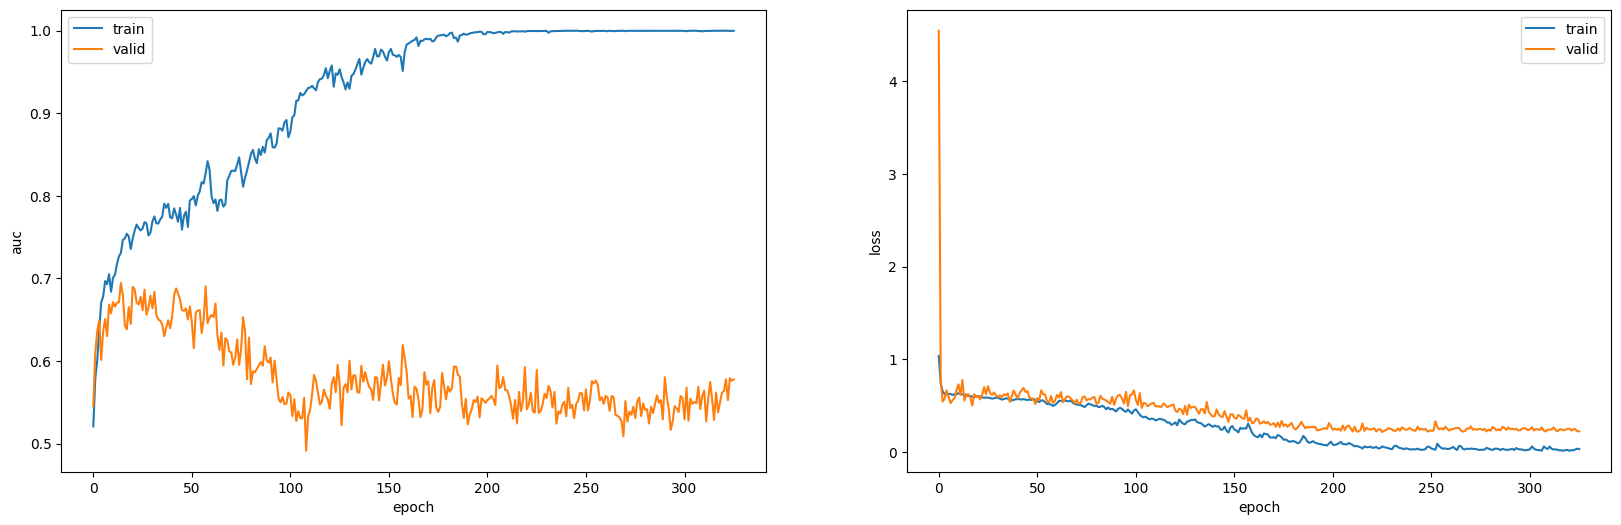

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
ax = axs[0]
ax.plot(clf.history['train_auc'], label="train")
ax.plot(clf.history['valid_auc'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('auc')
ax.legend()

ax = axs[1]
ax.plot(clf.history['loss'], label="train")
ax.plot(clf.history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

plt.show()

In [ ]:
# saved_filename = clf.save_model('test_model_yb')

loaded_clf = TabNetClassifier()
loaded_clf.load_model('test_model_yb.zip')

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = f1_score(y_pred=loaded_y_pred, y_true=y_test, average="weighted")

print(f"FINAL TEST SCORE : {loaded_test_acc}")

assert(test_acc == loaded_test_acc)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


RuntimeError: ignored

In [ ]:
loaded_clf

TabNetClassifier(n_d=64, n_a=64, n_steps=5, gamma=1.5, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.3, lambda_sparse=0.0001, seed=0, clip_value=2.0, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={'gamma': 0.95, 'step_size': 20}, mask_type='sparsemax', input_dim=28, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

In [ ]:
accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

In [ ]:
pred_proba_class1 = clf.predict_proba(X_test)[:, 1]
print('max predict_proba:', np.round(np.max(pred_proba_class1), 2))

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
print('thresholds[0](=max predict_proba+1):', np.round(thresholds[0], 2))

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

max predict_proba: 1.0
thresholds[0](=max predict_proba+1): 2.0
샘플 추출을 위한 임곗값 배열의 index: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101]
샘플 index로 추출한 임곗값:  [1.   0.67 0.62 0.57 0.55 0.49 0.47 0.42 0.39 0.34 0.26 0.08 0.08 0.04
 0.02 0.01 0.   0.   0.   0.   0.  ]
샘플 임곗값별 FPR:  [0.    0.053 0.068 0.087 0.096 0.126 0.147 0.175 0.2   0.231 0.299 0.436
 0.443 0.484 0.536 0.612 0.645 0.702 0.748 0.783 0.91 ]
샘플 임곗값별 TPR:  [0.    0.039 0.098 0.137 0.196 0.235 0.294 0.333 0.392 0.431 0.49  0.529
 0.588 0.647 0.706 0.745 0.804 0.843 0.902 0.941 1.   ]


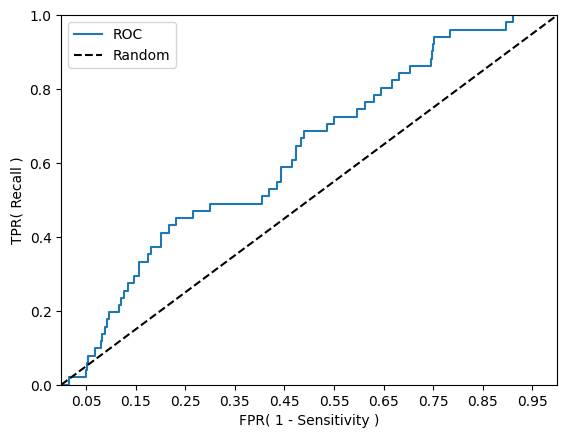

ROC AUC 값: 0.6247


In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, clf.predict_proba(X_test)[:, 1] )

pred_proba = clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

In [ ]:
# dataset = {
#     "X_train":X_train,
#     "X_test":X_test,
#     "X_valid":X_valid,
#     "y_train":y_train,
#     "y_test":y_test,
#     "y_valid":y_valid
# }

In [ ]:
#  with open('KrYbdataset.pkl', 'wb') as file_pi:
#         pickle.dump(dataset, file_pi)

In [ ]:
#  with open('YbKrHistory.pkl', 'wb') as file_pi:
#         pickle.dump(clf.history, file_pi)

In [ ]:
dataset = pickle.load(open('KrYbdataset.pkl', "rb"))
X_train = dataset["X_train"]
X_test = dataset["X_test"]
X_valid = dataset["X_valid"]
y_train = dataset["y_train"]
y_test = dataset["y_test"]
y_valid = dataset["y_valid"]

In [ ]:
pd.DataFrame(y_train).value_counts()

0    22190
1      440
dtype: int64

In [ ]:
history = pickle.load(open('YbKrHistory.pkl', "rb"))

<Axes: xlabel='importances', ylabel='feature'>

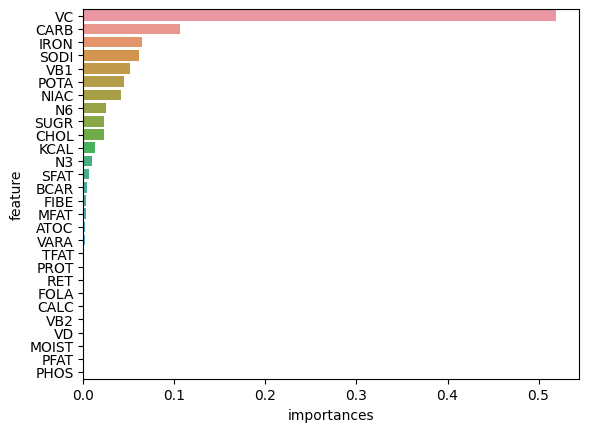

In [ ]:
def get_FI():
    importance = clf.feature_importances_
    feature = df.columns[1:]
    importances = pd.DataFrame()
    importances["feature"] = feature
    importances["importances"] = importance
    importances.sort_values("importances", ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)

    return importances

FI = get_FI()
sb.barplot(x="importances", y="feature", data=FI)

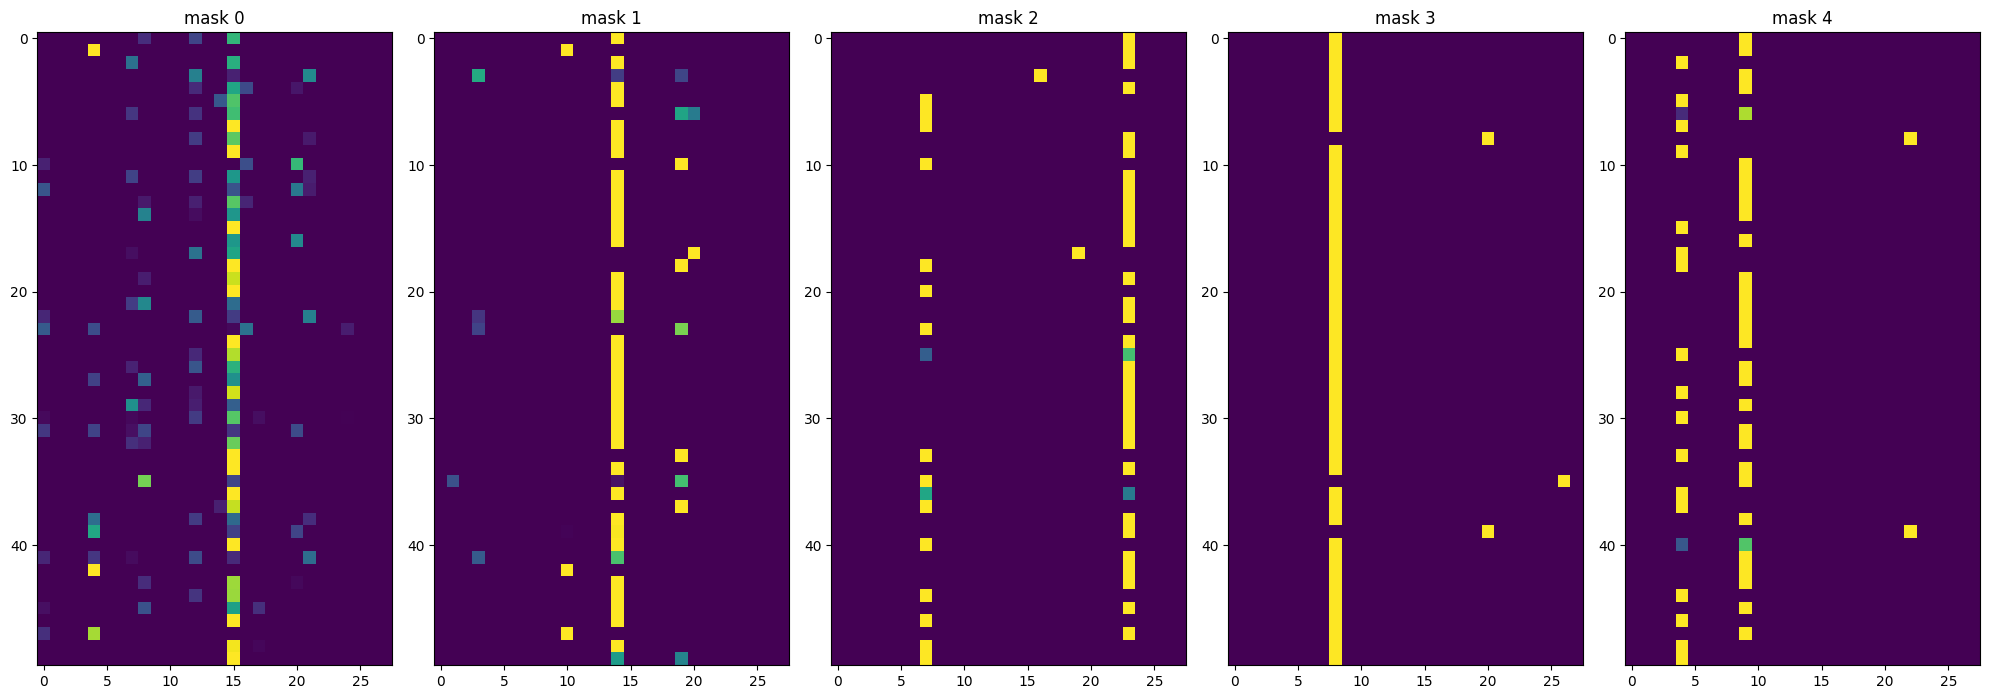

In [ ]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 5, figsize=(20,15))
for i in range(5):
    ax = axs[i]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
plt.tight_layout()

In [ ]:
len(masks)

In [ ]:
masks[0].max()

In [ ]:
df.columns[14:18]

#### OB

In [ ]:
df = df_ob_procd

In [ ]:
try:
  df.insert(0,"DC",0)
except:
  pass
df.loc[df['DC1'] == 1, 'DC'] = 1
df.loc[df['DC2'] == 1, 'DC'] = 1
df.loc[df['DC3'] == 1, 'DC'] = 1
df.loc[df['DC4'] == 1, 'DC'] = 1
df.loc[df['DC5'] == 1, 'DC'] = 1
df.loc[df['DC6'] == 1, 'DC'] = 1
df = df.drop(columns=[f"DC{i}" for i in range(1,6+1)])

In [ ]:
categorical_columns = ["DC"]
categorical_dims =  {}
for col in df.columns:
    if col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

DC 2


In [ ]:
df.to_csv("KrObDataset.csv")

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 1000
Hist = {}
Score = {}
for i in range(5):
  print(f"{i+1} Cycle")

  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss', 'accuracy', 'auc'],
      max_epochs=max_epochs , patience=200,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  preds = clf.predict_proba(X_test)

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  acc = accuracy_score(y_pred=y_pred, y_true=y_test)
  prec = precision_score(y_pred=y_pred, y_true=y_test, average="weighted")
  rec = recall_score(y_pred=y_pred, y_true=y_test, average="weighted")

  Hist[i] = clf.history
  Score[i] = [test_acc, acc, prec, rec]

1 Cycle
epoch 0  | loss: 1.085   | train_logloss: 6.79229 | train_accuracy: 0.26667 | train_auc: 0.49787 | valid_logloss: 6.97587 | valid_accuracy: 0.25024 | valid_auc: 0.4625  |  0:00:13s
epoch 1  | loss: 0.91132 | train_logloss: 2.35941 | train_accuracy: 0.63599 | train_auc: 0.48072 | valid_logloss: 2.38654 | valid_accuracy: 0.65894 | valid_auc: 0.53691 |  0:00:22s
epoch 2  | loss: 0.91757 | train_logloss: 1.87745 | train_accuracy: 0.54215 | train_auc: 0.50108 | valid_logloss: 2.00235 | valid_accuracy: 0.52271 | valid_auc: 0.49019 |  0:00:30s
epoch 3  | loss: 0.93665 | train_logloss: 1.40381 | train_accuracy: 0.66534 | train_auc: 0.50163 | valid_logloss: 1.55673 | valid_accuracy: 0.66184 | valid_auc: 0.46802 |  0:00:36s
epoch 4  | loss: 0.87421 | train_logloss: 1.01726 | train_accuracy: 0.67126 | train_auc: 0.49786 | valid_logloss: 1.0119  | valid_accuracy: 0.66087 | valid_auc: 0.51984 |  0:00:45s
epoch 5  | loss: 0.78695 | train_logloss: 0.67541 | train_accuracy: 0.68406 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


2 Cycle
epoch 0  | loss: 1.16678 | train_logloss: 1.85211 | train_accuracy: 0.77923 | train_auc: 0.5326  | valid_logloss: 2.06171 | valid_accuracy: 0.76232 | valid_auc: 0.53946 |  0:00:04s
epoch 1  | loss: 1.08986 | train_logloss: 2.73328 | train_accuracy: 0.44143 | train_auc: 0.50954 | valid_logloss: 2.68341 | valid_accuracy: 0.45121 | valid_auc: 0.5257  |  0:00:08s
epoch 2  | loss: 0.94926 | train_logloss: 2.8201  | train_accuracy: 0.39638 | train_auc: 0.49604 | valid_logloss: 2.74483 | valid_accuracy: 0.37005 | valid_auc: 0.49936 |  0:00:11s
epoch 3  | loss: 0.89383 | train_logloss: 0.89408 | train_accuracy: 0.61969 | train_auc: 0.51242 | valid_logloss: 0.86738 | valid_accuracy: 0.62899 | valid_auc: 0.55878 |  0:00:13s
epoch 4  | loss: 0.81316 | train_logloss: 1.20639 | train_accuracy: 0.4814  | train_auc: 0.51174 | valid_logloss: 1.31396 | valid_accuracy: 0.4744  | valid_auc: 0.46299 |  0:00:16s
epoch 5  | loss: 0.77832 | train_logloss: 0.93582 | train_accuracy: 0.61824 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


3 Cycle
epoch 0  | loss: 1.13227 | train_logloss: 2.2413  | train_accuracy: 0.74082 | train_auc: 0.48277 | valid_logloss: 2.19874 | valid_accuracy: 0.7285  | valid_auc: 0.4994  |  0:00:02s
epoch 1  | loss: 0.91002 | train_logloss: 5.25262 | train_accuracy: 0.39469 | train_auc: 0.50516 | valid_logloss: 5.34521 | valid_accuracy: 0.3913  | valid_auc: 0.5204  |  0:00:06s
epoch 2  | loss: 0.89146 | train_logloss: 1.2701  | train_accuracy: 0.69082 | train_auc: 0.53151 | valid_logloss: 1.34647 | valid_accuracy: 0.69275 | valid_auc: 0.52703 |  0:00:09s
epoch 3  | loss: 0.87166 | train_logloss: 1.88698 | train_accuracy: 0.72657 | train_auc: 0.50451 | valid_logloss: 1.79338 | valid_accuracy: 0.74493 | valid_auc: 0.5111  |  0:00:12s
epoch 4  | loss: 0.84025 | train_logloss: 0.91113 | train_accuracy: 0.69976 | train_auc: 0.51682 | valid_logloss: 0.93095 | valid_accuracy: 0.68406 | valid_auc: 0.47134 |  0:00:15s
epoch 5  | loss: 0.79979 | train_logloss: 1.52279 | train_accuracy: 0.55942 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


4 Cycle
epoch 0  | loss: 1.15014 | train_logloss: 1.24724 | train_accuracy: 0.83865 | train_auc: 0.50129 | valid_logloss: 1.41705 | valid_accuracy: 0.82222 | valid_auc: 0.52658 |  0:00:02s
epoch 1  | loss: 0.93674 | train_logloss: 1.04709 | train_accuracy: 0.79879 | train_auc: 0.49593 | valid_logloss: 1.16211 | valid_accuracy: 0.78937 | valid_auc: 0.49905 |  0:00:06s
epoch 2  | loss: 0.87826 | train_logloss: 1.4473  | train_accuracy: 0.69541 | train_auc: 0.53462 | valid_logloss: 1.54473 | valid_accuracy: 0.6715  | valid_auc: 0.524   |  0:00:09s
epoch 3  | loss: 0.86795 | train_logloss: 3.83122 | train_accuracy: 0.2756  | train_auc: 0.47914 | valid_logloss: 3.9086  | valid_accuracy: 0.28019 | valid_auc: 0.41706 |  0:00:12s
epoch 4  | loss: 0.83587 | train_logloss: 1.06877 | train_accuracy: 0.59034 | train_auc: 0.52591 | valid_logloss: 1.12178 | valid_accuracy: 0.60483 | valid_auc: 0.53641 |  0:00:14s
epoch 5  | loss: 0.79669 | train_logloss: 0.98419 | train_accuracy: 0.64275 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


5 Cycle
epoch 0  | loss: 1.13886 | train_logloss: 4.98907 | train_accuracy: 0.52874 | train_auc: 0.48452 | valid_logloss: 4.96716 | valid_accuracy: 0.52077 | valid_auc: 0.52142 |  0:00:03s
epoch 1  | loss: 0.95162 | train_logloss: 1.40719 | train_accuracy: 0.71679 | train_auc: 0.49769 | valid_logloss: 1.48035 | valid_accuracy: 0.67246 | valid_auc: 0.48645 |  0:00:07s
epoch 2  | loss: 0.8674  | train_logloss: 2.7835  | train_accuracy: 0.37234 | train_auc: 0.5087  | valid_logloss: 2.74116 | valid_accuracy: 0.37005 | valid_auc: 0.50415 |  0:00:11s
epoch 3  | loss: 0.89123 | train_logloss: 1.30313 | train_accuracy: 0.54275 | train_auc: 0.54598 | valid_logloss: 1.42645 | valid_accuracy: 0.54589 | valid_auc: 0.50049 |  0:00:15s
epoch 4  | loss: 0.82386 | train_logloss: 1.25697 | train_accuracy: 0.53454 | train_auc: 0.50512 | valid_logloss: 1.26576 | valid_accuracy: 0.53816 | valid_auc: 0.57044 |  0:00:17s
epoch 5  | loss: 0.7956  | train_logloss: 1.11999 | train_accuracy: 0.48732 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
a = "KrOb"
with open(f'{a}Hist.pkl', 'wb') as file_pi:
      pickle.dump(Hist, file_pi)
with open(f'{a}Score.pkl', 'wb') as file_pi:
      pickle.dump(Score, file_pi)

In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()


X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

roc_curve_plot(y_test, clf.predict_proba(X_test)[:, 1] )

pred_proba = clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

In [ ]:
a = 0
while a <= 200:
  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  max_epochs = 1000

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['accuracy', 'auc', 'logloss'],
      max_epochs=max_epochs , patience=100,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  a = len(clf.history["loss"])

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

  preds = clf.predict_proba(X_test)
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  print(test_acc)

epoch 0  | loss: 1.51701 | train_accuracy: 0.582   | train_auc: 0.52292 | train_logloss: 4.72158 | valid_accuracy: 0.5971  | valid_auc: 0.53493 | valid_logloss: 4.29998 |  0:00:04s
epoch 1  | loss: 1.4523  | train_accuracy: 0.51655 | train_auc: 0.51917 | train_logloss: 4.24408 | valid_accuracy: 0.55072 | valid_auc: 0.58017 | valid_logloss: 3.83954 |  0:00:10s
epoch 2  | loss: 1.4082  | train_accuracy: 0.40326 | train_auc: 0.51679 | train_logloss: 4.90178 | valid_accuracy: 0.39614 | valid_auc: 0.52774 | valid_logloss: 4.81442 |  0:00:14s
epoch 3  | loss: 1.35734 | train_accuracy: 0.55121 | train_auc: 0.53173 | train_logloss: 2.78633 | valid_accuracy: 0.55072 | valid_auc: 0.53019 | valid_logloss: 2.48864 |  0:00:17s
epoch 4  | loss: 1.34846 | train_accuracy: 0.49469 | train_auc: 0.53175 | train_logloss: 2.79844 | valid_accuracy: 0.48406 | valid_auc: 0.49152 | valid_logloss: 2.76307 |  0:00:19s
epoch 5  | loss: 1.26669 | train_accuracy: 0.49577 | train_auc: 0.52348 | train_logloss: 2.3287

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.7036044088588819


In [ ]:
# saved_filename = clf.save_model('test_model_ob_2')

loaded_clf = TabNetClassifier()
loaded_clf.load_model('test_model_ob_2.zip')

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = f1_score(y_pred=loaded_y_pred, y_true=y_test, average="weighted")

print(f"FINAL TEST SCORE : {loaded_test_acc}")

assert(test_acc == loaded_test_acc)

Successfully saved model at test_model_ob_2.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


FINAL TEST SCORE : 0.7440310552922188


In [ ]:
 dataset = {
    "X_train":X_train,
    "X_test":X_test,
    "X_valid":X_valid,
    "y_train":y_train,
    "y_test":y_test,
    "y_valid":y_valid
}

with open('KrObdataset_2.pkl', 'wb') as file_pi:
        pickle.dump(dataset, file_pi)

In [ ]:
 with open('ObKrHistory_2.pkl', 'wb') as file_pi:
        pickle.dump(clf.history, file_pi)

In [ ]:
dataset = pickle.load(open('KrObdataset_2.pkl', "rb"))
X_train = dataset["X_train"]
X_test = dataset["X_test"]
X_valid = dataset["X_valid"]
y_train = dataset["y_train"]
y_test = dataset["y_test"]
y_valid = dataset["y_valid"]

In [ ]:
pred_proba_class1 = loaded_clf.predict_proba(X_test)[:, 1]
print('max predict_proba:', np.round(np.max(pred_proba_class1), 2))

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
print('thresholds[0](=max predict_proba+1):', np.round(thresholds[0], 2))

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

max predict_proba: 0.97
thresholds[0](=max predict_proba+1): 1.97
샘플 추출을 위한 임곗값 배열의 index: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126]
샘플 index로 추출한 임곗값:  [0.97 0.69 0.67 0.63 0.6  0.57 0.57 0.54 0.52 0.51 0.5  0.49 0.48 0.46
 0.45 0.43 0.42 0.41 0.41 0.39 0.38 0.35 0.33 0.3  0.23 0.  ]
샘플 임곗값별 FPR:  [0.001 0.029 0.035 0.055 0.079 0.129 0.139 0.211 0.245 0.29  0.327 0.384
 0.41  0.511 0.54  0.607 0.627 0.676 0.685 0.761 0.785 0.839 0.869 0.913
 0.947 1.   ]
샘플 임곗값별 TPR:  [0.    0.029 0.088 0.118 0.162 0.191 0.265 0.294 0.338 0.382 0.426 0.456
 0.5   0.529 0.574 0.603 0.676 0.706 0.75  0.779 0.824 0.853 0.897 0.926
 0.971 1.   ]


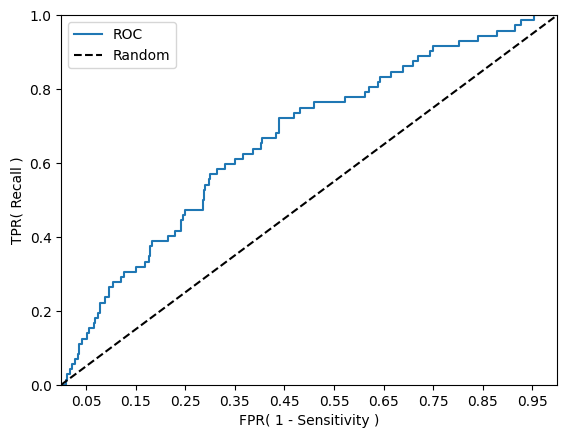

ROC AUC 값: 0.6629


In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()


X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

roc_curve_plot(y_test, loaded_clf.predict_proba(X_test)[:, 1] )

pred_proba = loaded_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

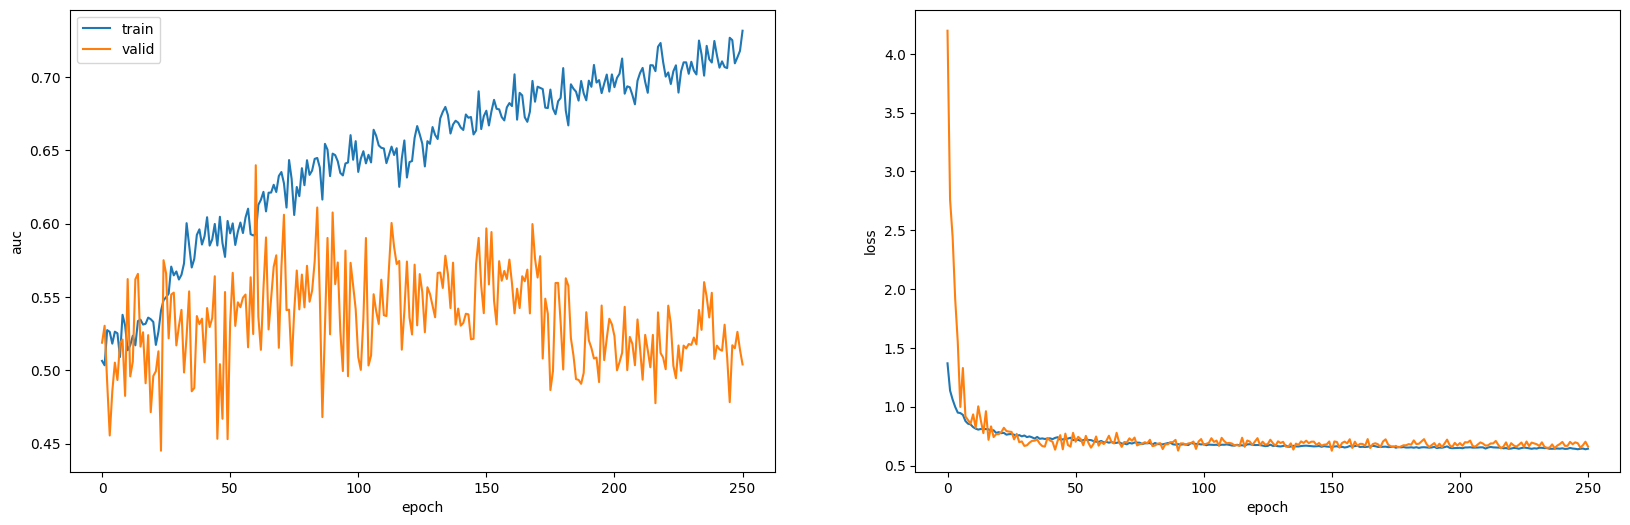

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
ax = axs[0]
ax.plot(clf.history['train_auc'], label="train")
ax.plot(clf.history['valid_auc'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('auc')
ax.legend()

ax = axs[1]
ax.plot(clf.history['loss'], label="train")
ax.plot(clf.history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

In [ ]:
history = pickle.load(open('YbKrHistory.pkl', "rb"))

RuntimeError: ignored

In [ ]:
history.history.keys()

dict_keys(['loss', 'lr', 'train_auc', 'train_logloss', 'valid_auc', 'valid_logloss'])

In [ ]:
plt.plot(history['train_acc'], label="train")
plt.plot(history['valid_auc'], label="valid")
plt.set_xlabel('epoch')
plt.set_ylabel('auc')
plt.legend()

<Axes: xlabel='importances', ylabel='feature'>

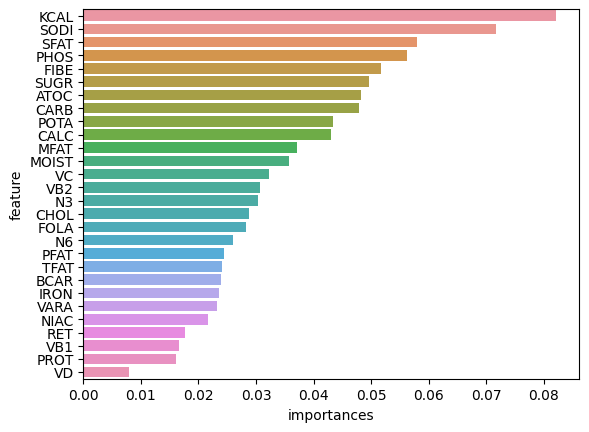

In [ ]:
def get_FI():
    importance = clf.feature_importances_
    feature = df.columns[1:]
    importances = pd.DataFrame()
    importances["feature"] = feature
    importances["importances"] = importance
    importances.sort_values("importances", ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)

    return importances

FI = get_FI()
sb.barplot(x="importances", y="feature", data=FI)

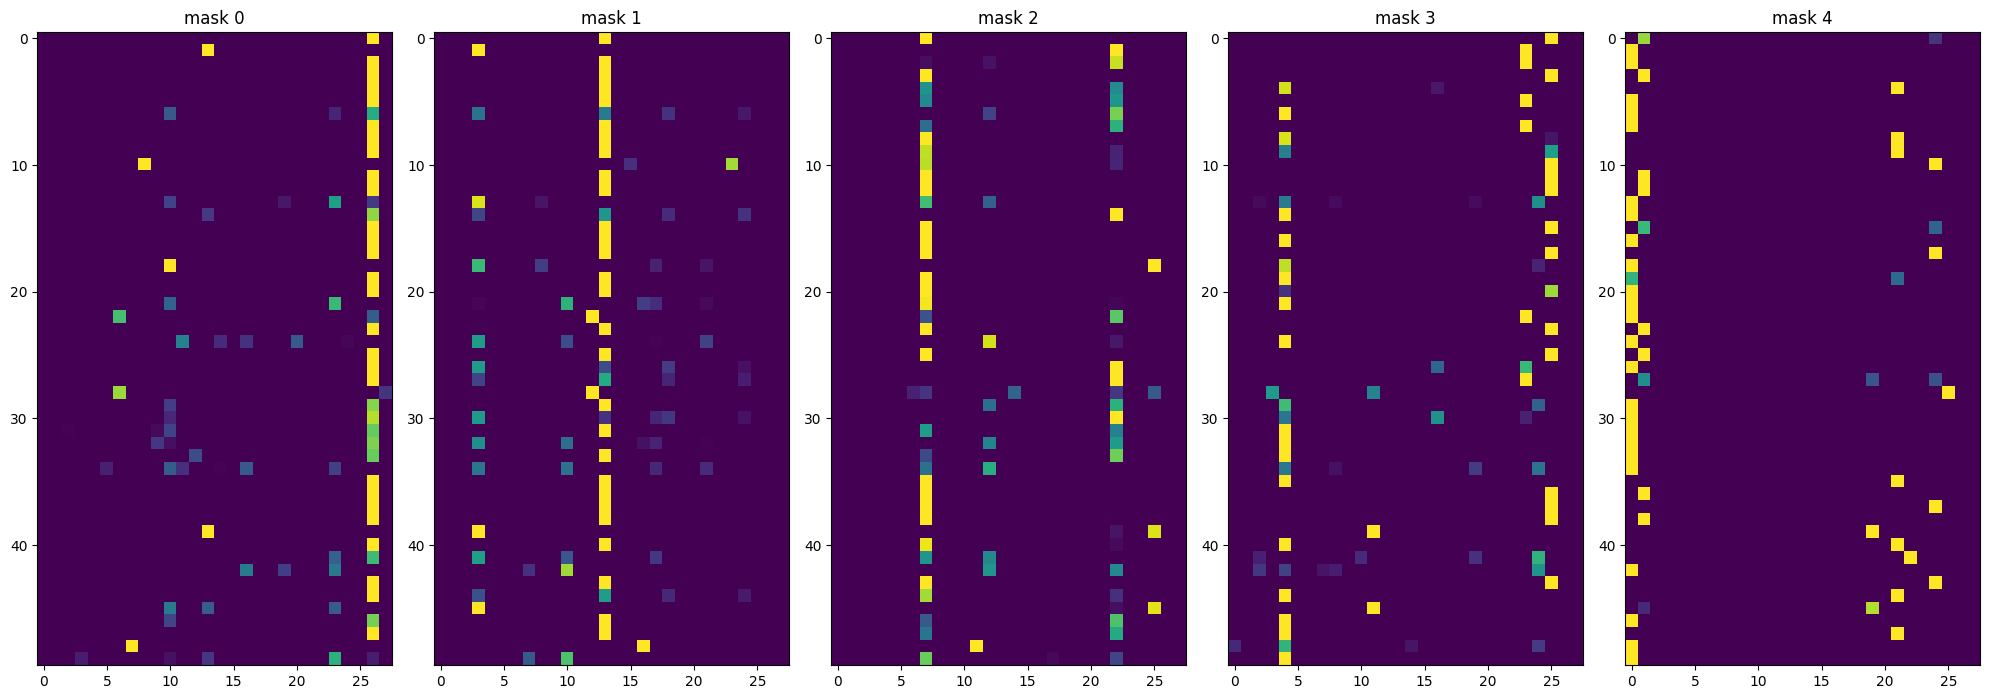

In [ ]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 5, figsize=(20,15))
for i in range(5):
    ax = axs[i]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
plt.tight_layout()

#### YBOB분리X

In [ ]:
df = pd.concat([df_yb_procd, df_ob_procd])

In [ ]:
try:
  df.insert(0,"DC",0)
except:
  pass
df.loc[df['DC1'] == 1, 'DC'] = 1
df.loc[df['DC2'] == 1, 'DC'] = 1
df.loc[df['DC3'] == 1, 'DC'] = 1
df.loc[df['DC4'] == 1, 'DC'] = 1
df.loc[df['DC5'] == 1, 'DC'] = 1
df.loc[df['DC6'] == 1, 'DC'] = 1
df = df.drop(columns=[f"DC{i}" for i in range(1,6+1)])

In [ ]:
categorical_columns = ["DC"]
categorical_dims =  {}
for col in df.columns:
    if col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

DC 2


In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
test_acc=0
while test_acc < 0.85:
  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  max_epochs = 1000

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      # eval_metric=['balanced_accuracy'],
      max_epochs=max_epochs , patience=100,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

  preds = clf.predict_proba(X_test)
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  print(test_acc)

epoch 0  | loss: 0.97484 | train_auc: 0.56787 | valid_auc: 0.5958  |  0:00:09s
epoch 1  | loss: 0.70262 | train_auc: 0.5618  | valid_auc: 0.59281 |  0:00:19s
epoch 2  | loss: 0.67009 | train_auc: 0.4704  | valid_auc: 0.43199 |  0:00:29s
epoch 3  | loss: 0.66565 | train_auc: 0.58338 | valid_auc: 0.57786 |  0:00:39s
epoch 4  | loss: 0.65918 | train_auc: 0.55392 | valid_auc: 0.58615 |  0:00:48s
epoch 5  | loss: 0.65659 | train_auc: 0.58951 | valid_auc: 0.57124 |  0:00:58s
epoch 6  | loss: 0.66009 | train_auc: 0.60502 | valid_auc: 0.60705 |  0:01:08s
epoch 7  | loss: 0.66162 | train_auc: 0.61741 | valid_auc: 0.58175 |  0:01:18s
epoch 8  | loss: 0.66496 | train_auc: 0.60524 | valid_auc: 0.59615 |  0:01:27s
epoch 9  | loss: 0.66184 | train_auc: 0.59984 | valid_auc: 0.59155 |  0:01:37s
epoch 10 | loss: 0.66027 | train_auc: 0.5471  | valid_auc: 0.56055 |  0:01:46s
epoch 11 | loss: 0.65292 | train_auc: 0.53743 | valid_auc: 0.53593 |  0:01:56s
epoch 12 | loss: 0.65647 | train_auc: 0.61173 | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.6472392964220617
epoch 0  | loss: 1.01205 | train_auc: 0.50811 | valid_auc: 0.47628 |  0:00:10s
epoch 1  | loss: 0.72788 | train_auc: 0.52004 | valid_auc: 0.51713 |  0:00:19s
epoch 2  | loss: 0.67946 | train_auc: 0.48422 | valid_auc: 0.53361 |  0:00:28s
epoch 3  | loss: 0.6661  | train_auc: 0.55476 | valid_auc: 0.49796 |  0:00:39s
epoch 4  | loss: 0.66481 | train_auc: 0.4789  | valid_auc: 0.50204 |  0:00:48s
epoch 5  | loss: 0.65662 | train_auc: 0.62724 | valid_auc: 0.65242 |  0:00:57s
epoch 6  | loss: 0.65267 | train_auc: 0.58455 | valid_auc: 0.59864 |  0:01:07s
epoch 7  | loss: 0.65221 | train_auc: 0.59681 | valid_auc: 0.57014 |  0:01:17s
epoch 8  | loss: 0.65615 | train_auc: 0.64552 | valid_auc: 0.668   |  0:01:26s
epoch 9  | loss: 0.64846 | train_auc: 0.64882 | valid_auc: 0.65417 |  0:01:36s
epoch 10 | loss: 0.65032 | train_auc: 0.62111 | valid_auc: 0.59592 |  0:01:46s
epoch 11 | loss: 0.65866 | train_auc: 0.62287 | valid_auc: 0.60842 |  0:01:55s
epoch 12 | loss: 0.66232 | train_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.7125851578493559
epoch 0  | loss: 0.96954 | train_auc: 0.49906 | valid_auc: 0.43209 |  0:00:09s
epoch 1  | loss: 0.71833 | train_auc: 0.55805 | valid_auc: 0.49835 |  0:00:19s
epoch 2  | loss: 0.66766 | train_auc: 0.4998  | valid_auc: 0.50027 |  0:00:29s
epoch 3  | loss: 0.6616  | train_auc: 0.62375 | valid_auc: 0.58885 |  0:00:39s
epoch 4  | loss: 0.65819 | train_auc: 0.5     | valid_auc: 0.5     |  0:00:48s
epoch 5  | loss: 0.66094 | train_auc: 0.59874 | valid_auc: 0.58226 |  0:00:58s
epoch 6  | loss: 0.65279 | train_auc: 0.57055 | valid_auc: 0.5572  |  0:01:08s
epoch 7  | loss: 0.64968 | train_auc: 0.60457 | valid_auc: 0.5939  |  0:01:17s
epoch 8  | loss: 0.64958 | train_auc: 0.63594 | valid_auc: 0.61078 |  0:01:27s
epoch 9  | loss: 0.65078 | train_auc: 0.61106 | valid_auc: 0.58752 |  0:01:37s
epoch 10 | loss: 0.64942 | train_auc: 0.61408 | valid_auc: 0.5897  |  0:01:45s
epoch 11 | loss: 0.64304 | train_auc: 0.58964 | valid_auc: 0.52688 |  0:01:55s
epoch 12 | loss: 0.64457 | train_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.7002094602471209
epoch 0  | loss: 0.97825 | train_auc: 0.50695 | valid_auc: 0.51814 |  0:00:09s
epoch 1  | loss: 0.73829 | train_auc: 0.59764 | valid_auc: 0.61299 |  0:00:18s
epoch 2  | loss: 0.67003 | train_auc: 0.60407 | valid_auc: 0.61415 |  0:00:28s
epoch 3  | loss: 0.66773 | train_auc: 0.60488 | valid_auc: 0.61734 |  0:00:38s
epoch 4  | loss: 0.65636 | train_auc: 0.59305 | valid_auc: 0.59882 |  0:00:47s
epoch 5  | loss: 0.65265 | train_auc: 0.61604 | valid_auc: 0.61279 |  0:00:57s
epoch 6  | loss: 0.65465 | train_auc: 0.64066 | valid_auc: 0.64614 |  0:01:07s
epoch 7  | loss: 0.651   | train_auc: 0.60433 | valid_auc: 0.55421 |  0:01:16s
epoch 8  | loss: 0.65318 | train_auc: 0.60416 | valid_auc: 0.553   |  0:01:25s
epoch 9  | loss: 0.6517  | train_auc: 0.57353 | valid_auc: 0.58221 |  0:01:35s
epoch 10 | loss: 0.6515  | train_auc: 0.56679 | valid_auc: 0.55383 |  0:01:45s
epoch 11 | loss: 0.64173 | train_auc: 0.62564 | valid_auc: 0.59361 |  0:01:54s
epoch 12 | loss: 0.6481  | train_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.6538955891355429
epoch 0  | loss: 1.04604 | train_auc: 0.53051 | valid_auc: 0.53211 |  0:00:11s
epoch 1  | loss: 0.71386 | train_auc: 0.54871 | valid_auc: 0.56736 |  0:00:22s
epoch 2  | loss: 0.66589 | train_auc: 0.57853 | valid_auc: 0.60486 |  0:00:32s
epoch 3  | loss: 0.65737 | train_auc: 0.58856 | valid_auc: 0.56493 |  0:00:43s
epoch 4  | loss: 0.66587 | train_auc: 0.60611 | valid_auc: 0.60099 |  0:00:54s
epoch 5  | loss: 0.66094 | train_auc: 0.50063 | valid_auc: 0.57499 |  0:01:05s
epoch 6  | loss: 0.65657 | train_auc: 0.60948 | valid_auc: 0.56616 |  0:01:15s
epoch 7  | loss: 0.65825 | train_auc: 0.61976 | valid_auc: 0.58928 |  0:01:24s
epoch 8  | loss: 0.65583 | train_auc: 0.63049 | valid_auc: 0.58447 |  0:01:35s
epoch 9  | loss: 0.65444 | train_auc: 0.61715 | valid_auc: 0.57883 |  0:01:46s
epoch 10 | loss: 0.65476 | train_auc: 0.61984 | valid_auc: 0.58824 |  0:01:56s
epoch 11 | loss: 0.65239 | train_auc: 0.63288 | valid_auc: 0.56731 |  0:02:05s
epoch 12 | loss: 0.64702 | train_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.706706206258647
epoch 0  | loss: 1.02335 | train_auc: 0.49132 | valid_auc: 0.49707 |  0:00:09s
epoch 1  | loss: 0.73008 | train_auc: 0.55459 | valid_auc: 0.57864 |  0:00:19s
epoch 2  | loss: 0.66944 | train_auc: 0.51828 | valid_auc: 0.50827 |  0:00:28s
epoch 3  | loss: 0.66284 | train_auc: 0.59996 | valid_auc: 0.59814 |  0:00:37s
epoch 4  | loss: 0.65414 | train_auc: 0.6194  | valid_auc: 0.61192 |  0:00:47s
epoch 5  | loss: 0.65717 | train_auc: 0.60791 | valid_auc: 0.57756 |  0:00:56s
epoch 6  | loss: 0.65236 | train_auc: 0.58968 | valid_auc: 0.60048 |  0:01:05s
epoch 7  | loss: 0.65078 | train_auc: 0.61728 | valid_auc: 0.59602 |  0:01:15s
epoch 8  | loss: 0.64789 | train_auc: 0.60493 | valid_auc: 0.59535 |  0:01:24s
epoch 9  | loss: 0.6481  | train_auc: 0.58036 | valid_auc: 0.56879 |  0:01:34s
epoch 10 | loss: 0.6524  | train_auc: 0.61773 | valid_auc: 0.63614 |  0:01:43s
epoch 11 | loss: 0.64516 | train_auc: 0.59839 | valid_auc: 0.62299 |  0:01:52s
epoch 12 | loss: 0.65007 | train_a

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.6236285438868309
epoch 0  | loss: 0.94787 | train_auc: 0.50805 | valid_auc: 0.4822  |  0:00:08s
epoch 1  | loss: 0.71493 | train_auc: 0.49658 | valid_auc: 0.51174 |  0:00:18s
epoch 2  | loss: 0.66908 | train_auc: 0.58339 | valid_auc: 0.56444 |  0:00:28s
epoch 3  | loss: 0.66338 | train_auc: 0.55238 | valid_auc: 0.50054 |  0:00:36s
epoch 4  | loss: 0.65883 | train_auc: 0.57615 | valid_auc: 0.56842 |  0:00:46s
epoch 5  | loss: 0.66144 | train_auc: 0.59309 | valid_auc: 0.55728 |  0:00:55s
epoch 6  | loss: 0.65679 | train_auc: 0.57895 | valid_auc: 0.54801 |  0:01:03s
epoch 7  | loss: 0.66027 | train_auc: 0.59988 | valid_auc: 0.56231 |  0:01:12s
epoch 8  | loss: 0.65556 | train_auc: 0.61942 | valid_auc: 0.57896 |  0:01:21s
epoch 9  | loss: 0.65701 | train_auc: 0.58894 | valid_auc: 0.56341 |  0:01:30s
epoch 10 | loss: 0.65455 | train_auc: 0.64056 | valid_auc: 0.59426 |  0:01:39s
epoch 11 | loss: 0.65118 | train_auc: 0.62487 | valid_auc: 0.56321 |  0:01:48s
epoch 12 | loss: 0.65107 | train_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.6840596397421844
epoch 0  | loss: 0.98777 | train_auc: 0.55514 | valid_auc: 0.52932 |  0:00:09s
epoch 1  | loss: 0.70897 | train_auc: 0.50914 | valid_auc: 0.54823 |  0:00:18s
epoch 2  | loss: 0.6744  | train_auc: 0.56991 | valid_auc: 0.56101 |  0:00:26s
epoch 3  | loss: 0.66438 | train_auc: 0.58928 | valid_auc: 0.56472 |  0:00:36s
epoch 4  | loss: 0.65898 | train_auc: 0.5144  | valid_auc: 0.49463 |  0:00:45s
epoch 5  | loss: 0.6592  | train_auc: 0.48609 | valid_auc: 0.49085 |  0:00:53s
epoch 6  | loss: 0.656   | train_auc: 0.54364 | valid_auc: 0.5554  |  0:01:02s
epoch 7  | loss: 0.65223 | train_auc: 0.54294 | valid_auc: 0.50093 |  0:01:11s
epoch 8  | loss: 0.65277 | train_auc: 0.48459 | valid_auc: 0.48311 |  0:01:20s
epoch 9  | loss: 0.65131 | train_auc: 0.59664 | valid_auc: 0.59856 |  0:01:29s
epoch 10 | loss: 0.64405 | train_auc: 0.59673 | valid_auc: 0.58641 |  0:01:38s
epoch 11 | loss: 0.64635 | train_auc: 0.58709 | valid_auc: 0.58196 |  0:01:48s
epoch 12 | loss: 0.65037 | train_

In [ ]:
saved_filename = clf.save_model('test_model_ybob')

loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = f1_score(y_pred=loaded_y_pred, y_true=y_test, average="weighted")

print(f"FINAL TEST SCORE : {loaded_test_acc}")

assert(test_acc == loaded_test_acc)

In [ ]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['loss'])
plt.plot(clf.history['valid_auc'])
plt.xlabel('epoch')
plt.legend(['train_auc', 'loss'])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
ax = axs[0]
ax.plot(clf.history['train_auc'], label="train")
ax.plot(clf.history['valid_auc'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('auc')
ax.legend()

ax = axs[1]
ax.plot(clf.history['loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

In [ ]:
def get_FI():
    importance = clf.feature_importances_
    feature = df.columns[1:]
    importances = pd.DataFrame()
    importances["feature"] = feature
    importances["importances"] = importance
    importances.sort_values("importances", ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)

    return importances

FI = get_FI()
sb.barplot(x="importances", y="feature", data=FI)

In [ ]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(2, 5, figsize=(20,15))
for i in range(10):
  if i < 5:
    ax = axs[0, i]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
  else:
    ax = axs[1, i-5]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
plt.tight_layout()

### 미국

#### YB

In [ ]:
df = df_yb_us

In [ ]:
try:
  df.insert(0,"DC",0)
except:
  pass
df.loc[df['DC1'] == 1, 'DC'] = 1
df.loc[df['DC2'] == 1, 'DC'] = 1
df.loc[df['DC3'] == 1, 'DC'] = 1
df.loc[df['DC4'] == 1, 'DC'] = 1
df.loc[df['DC5'] == 1, 'DC'] = 1
df.loc[df['DC6'] == 1, 'DC'] = 1
df = df.drop(columns=[f"DC{i}" for i in range(1,6+1)])

In [ ]:
categorical_columns = ["DC"]
categorical_dims =  {}
for col in df.columns:
    if col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

DC 2


In [ ]:
df.to_csv("UsYbDataset.csv")

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=11,
    gamma=1.5, n_independent=2, n_shared=2,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 1000
Hist = {}
Score = {}
for i in range(5):
  print(f"{i+1} Cycle")

  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss', 'accuracy', 'auc'],
      max_epochs=max_epochs , patience=300,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  preds = clf.predict_proba(X_test)

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  acc = accuracy_score(y_pred=y_pred, y_true=y_test)
  prec = precision_score(y_pred=y_pred, y_true=y_test, average="weighted")
  rec = recall_score(y_pred=y_pred, y_true=y_test, average="weighted")

  Hist[i] = clf.history
  Score[i] = [test_acc, acc, prec, rec]

1 Cycle
epoch 0  | loss: 1.58199 | train_logloss: 4.11978 | train_accuracy: 0.50042 | train_auc: 0.53049 | valid_logloss: 4.02754 | valid_accuracy: 0.50676 | valid_auc: 0.58185 |  0:00:10s
epoch 1  | loss: 1.82474 | train_logloss: 8.34976 | train_accuracy: 0.08557 | train_auc: 0.44366 | valid_logloss: 8.40797 | valid_accuracy: 0.08715 | valid_auc: 0.48969 |  0:00:16s
epoch 2  | loss: 1.76648 | train_logloss: 8.41403 | train_accuracy: 0.04232 | train_auc: 0.48837 | valid_logloss: 8.35444 | valid_accuracy: 0.0417  | valid_auc: 0.40205 |  0:00:24s
epoch 3  | loss: 1.52543 | train_logloss: 0.34473 | train_accuracy: 0.8917  | train_auc: 0.61447 | valid_logloss: 0.34281 | valid_accuracy: 0.89369 | valid_auc: 0.6677  |  0:00:30s
epoch 4  | loss: 1.03415 | train_logloss: 1.20162 | train_accuracy: 0.21492 | train_auc: 0.54678 | valid_logloss: 1.18564 | valid_accuracy: 0.21037 | valid_auc: 0.51096 |  0:00:38s
epoch 5  | loss: 0.77545 | train_logloss: 0.81385 | train_accuracy: 0.45764 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


2 Cycle
epoch 0  | loss: 1.63476 | train_logloss: 0.94156 | train_accuracy: 0.85342 | train_auc: 0.56873 | valid_logloss: 0.92372 | valid_accuracy: 0.8441  | valid_auc: 0.56024 |  0:00:06s
epoch 1  | loss: 1.56954 | train_logloss: 13.03696| train_accuracy: 0.02057 | train_auc: 0.46002 | valid_logloss: 13.16149| valid_accuracy: 0.01953 | valid_auc: 0.48341 |  0:00:13s
epoch 2  | loss: 4.54581 | train_logloss: 0.19925 | train_accuracy: 0.98131 | train_auc: 0.61124 | valid_logloss: 0.19661 | valid_accuracy: 0.9831  | valid_auc: 0.60378 |  0:00:19s
epoch 3  | loss: 1.14718 | train_logloss: 0.42393 | train_accuracy: 0.79546 | train_auc: 0.61114 | valid_logloss: 0.39725 | valid_accuracy: 0.80879 | valid_auc: 0.6423  |  0:00:27s
epoch 4  | loss: 0.71567 | train_logloss: 0.39829 | train_accuracy: 0.84116 | train_auc: 0.61296 | valid_logloss: 0.38733 | valid_accuracy: 0.84523 | valid_auc: 0.634   |  0:00:33s
epoch 5  | loss: 0.72139 | train_logloss: 0.32745 | train_accuracy: 0.9157  | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


3 Cycle
epoch 0  | loss: 1.92824 | train_logloss: 0.47433 | train_accuracy: 0.94965 | train_auc: 0.58201 | valid_logloss: 0.45358 | valid_accuracy: 0.95004 | valid_auc: 0.49512 |  0:00:06s
epoch 1  | loss: 1.66121 | train_logloss: 1.48074 | train_accuracy: 0.65607 | train_auc: 0.60608 | valid_logloss: 1.41883 | valid_accuracy: 0.64688 | valid_auc: 0.58424 |  0:00:13s
epoch 2  | loss: 1.08261 | train_logloss: 0.74599 | train_accuracy: 0.75146 | train_auc: 0.56985 | valid_logloss: 0.66516 | valid_accuracy: 0.76972 | valid_auc: 0.61827 |  0:00:19s
epoch 3  | loss: 0.9273  | train_logloss: 0.38496 | train_accuracy: 0.86624 | train_auc: 0.6289  | valid_logloss: 0.38725 | valid_accuracy: 0.86101 | valid_auc: 0.5626  |  0:00:27s
epoch 4  | loss: 0.83357 | train_logloss: 2.92211 | train_accuracy: 0.01926 | train_auc: 0.49062 | valid_logloss: 2.98854 | valid_accuracy: 0.01315 | valid_auc: 0.43793 |  0:00:33s
epoch 5  | loss: 2.1285  | train_logloss: 0.22865 | train_accuracy: 0.98112 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


4 Cycle
epoch 0  | loss: 2.30448 | train_logloss: 1.9455  | train_accuracy: 0.74559 | train_auc: 0.54493 | valid_logloss: 1.9357  | valid_accuracy: 0.74981 | valid_auc: 0.57111 |  0:00:06s
epoch 1  | loss: 2.37144 | train_logloss: 2.49002 | train_accuracy: 0.70909 | train_auc: 0.53605 | valid_logloss: 2.43397 | valid_accuracy: 0.71525 | valid_auc: 0.49184 |  0:00:13s
epoch 2  | loss: 1.85592 | train_logloss: 1.66595 | train_accuracy: 0.48962 | train_auc: 0.60442 | valid_logloss: 1.64484 | valid_accuracy: 0.48535 | valid_auc: 0.51659 |  0:00:19s
epoch 3  | loss: 1.32617 | train_logloss: 0.28575 | train_accuracy: 0.92598 | train_auc: 0.62133 | valid_logloss: 0.28259 | valid_accuracy: 0.92299 | valid_auc: 0.60299 |  0:00:26s
epoch 4  | loss: 0.80491 | train_logloss: 1.26399 | train_accuracy: 0.2462  | train_auc: 0.54346 | valid_logloss: 1.27407 | valid_accuracy: 0.23441 | valid_auc: 0.50701 |  0:00:33s
epoch 5  | loss: 0.87784 | train_logloss: 0.71437 | train_accuracy: 0.46229 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


5 Cycle
epoch 0  | loss: 1.54456 | train_logloss: 0.32965 | train_accuracy: 0.96233 | train_auc: 0.55743 | valid_logloss: 0.4042  | valid_accuracy: 0.95605 | valid_auc: 0.54001 |  0:00:06s
epoch 1  | loss: 1.96945 | train_logloss: 1.70142 | train_accuracy: 0.73197 | train_auc: 0.58847 | valid_logloss: 1.6394  | valid_accuracy: 0.72539 | valid_auc: 0.57196 |  0:00:12s
epoch 2  | loss: 1.76375 | train_logloss: 0.21557 | train_accuracy: 0.98206 | train_auc: 0.6051  | valid_logloss: 0.25787 | valid_accuracy: 0.97859 | valid_auc: 0.62118 |  0:00:19s
epoch 3  | loss: 2.41789 | train_logloss: 0.55184 | train_accuracy: 0.69599 | train_auc: 0.59853 | valid_logloss: 0.5538  | valid_accuracy: 0.70361 | valid_auc: 0.57312 |  0:00:25s
epoch 4  | loss: 0.80108 | train_logloss: 0.73891 | train_accuracy: 0.55434 | train_auc: 0.5784  | valid_logloss: 0.7297  | valid_accuracy: 0.56499 | valid_auc: 0.54558 |  0:00:33s
epoch 5  | loss: 0.70403 | train_logloss: 0.64996 | train_accuracy: 0.57942 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
a = "UsYb"
with open(f'{a}Hist.pkl', 'wb') as file_pi:
      pickle.dump(Hist, file_pi)
with open(f'{a}Score.pkl', 'wb') as file_pi:
      pickle.dump(Score, file_pi)

In [ ]:
a=0
test_acc = 0
while a < 200:
  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  max_epochs = 1000

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=[ 'accuracy',  'auc', 'logloss'],
      max_epochs=max_epochs , patience=100,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  a = len(clf.history["loss"])

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

  preds = clf.predict_proba(X_test)
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  print(test_acc)

epoch 0  | loss: 2.077   | train_accuracy: 0.77982 | train_auc: 0.54409 | train_logloss: 1.9904  | valid_accuracy: 0.77986 | valid_auc: 0.58402 | valid_logloss: 1.95531 |  0:00:31s
epoch 1  | loss: 1.49984 | train_accuracy: 0.68331 | train_auc: 0.53701 | train_logloss: 2.04556 | valid_accuracy: 0.68445 | valid_auc: 0.5266  | valid_logloss: 2.03044 |  0:01:04s
epoch 2  | loss: 1.42941 | train_accuracy: 0.63536 | train_auc: 0.52456 | train_logloss: 1.93045 | valid_accuracy: 0.61758 | valid_auc: 0.50817 | valid_logloss: 1.96247 |  0:01:20s
epoch 3  | loss: 1.37629 | train_accuracy: 0.66053 | train_auc: 0.55334 | train_logloss: 1.23201 | valid_accuracy: 0.65327 | valid_auc: 0.59131 | valid_logloss: 1.23401 |  0:01:35s
epoch 4  | loss: 1.31258 | train_accuracy: 0.58787 | train_auc: 0.53548 | train_logloss: 1.27256 | valid_accuracy: 0.59241 | valid_auc: 0.59706 | valid_logloss: 1.17469 |  0:01:51s
epoch 5  | loss: 1.24806 | train_accuracy: 0.55725 | train_auc: 0.55846 | train_logloss: 1.1025

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.9471511041758975
epoch 0  | loss: 2.17625 | train_accuracy: 0.76517 | train_auc: 0.55192 | train_logloss: 2.35661 | valid_accuracy: 0.77235 | valid_auc: 0.59092 | valid_logloss: 2.27219 |  0:00:15s
epoch 1  | loss: 1.48177 | train_accuracy: 0.61493 | train_auc: 0.56472 | train_logloss: 2.51626 | valid_accuracy: 0.61946 | valid_auc: 0.59322 | valid_logloss: 2.34082 |  0:00:31s
epoch 2  | loss: 1.43166 | train_accuracy: 0.62972 | train_auc: 0.5309  | train_logloss: 1.67226 | valid_accuracy: 0.6405  | valid_auc: 0.56961 | valid_logloss: 1.5032  |  0:00:47s
epoch 3  | loss: 1.37481 | train_accuracy: 0.59529 | train_auc: 0.56181 | train_logloss: 1.46841 | valid_accuracy: 0.5973  | valid_auc: 0.55587 | valid_logloss: 1.4979  |  0:01:03s
epoch 4  | loss: 1.27377 | train_accuracy: 0.57317 | train_auc: 0.56116 | train_logloss: 1.25709 | valid_accuracy: 0.56198 | valid_auc: 0.59398 | valid_logloss: 1.26114 |  0:01:19s
epoch 5  | loss: 1.27965 | train_accuracy: 0.56401 | train_auc: 0.54809 | tr

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.9002184386300206


In [ ]:
# saved_filename = clf.save_model('test_model_yb_us_2')

loaded_clf = TabNetClassifier()
loaded_clf.load_model('test_model_yb_us_2.zip')

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = f1_score(y_pred=loaded_y_pred, y_true=y_test, average="weighted")

print(f"FINAL TEST SCORE : {loaded_test_acc}")

assert(test_acc == loaded_test_acc)

Successfully saved model at test_model_yb_us_2.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


FINAL TEST SCORE : 0.9002184386300206


In [ ]:
accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

NameError: ignored

In [ ]:
dataset = {
    "X_train":X_train,
    "X_test":X_test,
    "X_valid":X_valid,
    "y_train":y_train,
    "y_test":y_test,
    "y_valid":y_valid
}

with open('UsYbdataset_2.pkl', 'wb') as file_pi:
        pickle.dump(dataset, file_pi)

In [ ]:
with open('YbUsHistory_2.pkl', 'wb') as file_pi:
        pickle.dump(clf.history, file_pi)

In [ ]:
history = pickle.load(open('YbUsHistory.pkl', "rb"))

In [ ]:
dataset = pickle.load(open('UsYbdataset_2.pkl', "rb"))
X_train = dataset["X_train"]
X_test = dataset["X_test"]
X_valid = dataset["X_valid"]
y_train = dataset["y_train"]
y_test = dataset["y_test"]
y_valid = dataset["y_valid"]

In [ ]:
pd.DataFrame(y_test).value_counts()

0    2620
1      42
dtype: int64

In [ ]:
pred_proba_class1 = loaded_clf.predict_proba(X_test)[:, 1]
print('max predict_proba:', np.round(np.max(pred_proba_class1), 2))

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
print('thresholds[0](=max predict_proba+1):', np.round(thresholds[0], 2))

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

max predict_proba: 0.86
thresholds[0](=max predict_proba+1): 1.86
샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86]
샘플 index로 추출한 임곗값:  [0.86 0.67 0.62 0.55 0.54 0.49 0.48 0.43 0.42 0.4  0.39 0.35 0.34 0.3
 0.28 0.25 0.24 0.04]
샘플 임곗값별 FPR:  [0.    0.014 0.027 0.075 0.093 0.161 0.182 0.282 0.304 0.357 0.374 0.463
 0.5   0.572 0.617 0.666 0.676 0.9  ]
샘플 임곗값별 TPR:  [0.    0.043 0.13  0.174 0.239 0.283 0.348 0.391 0.457 0.5   0.565 0.609
 0.674 0.717 0.783 0.826 0.891 0.935]


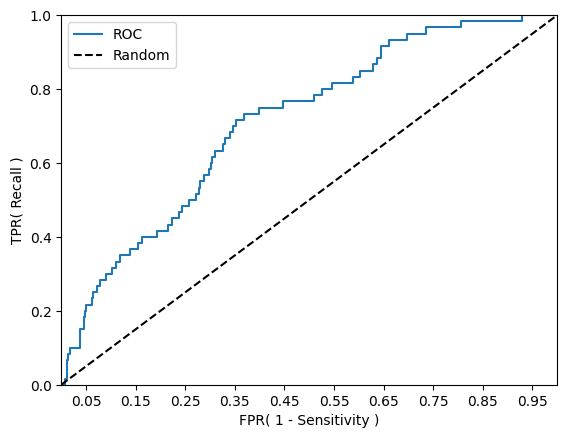

ROC AUC 값: 0.7119


In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

roc_curve_plot(y_test, loaded_clf.predict_proba(X_test)[:, 1] )

pred_proba = clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

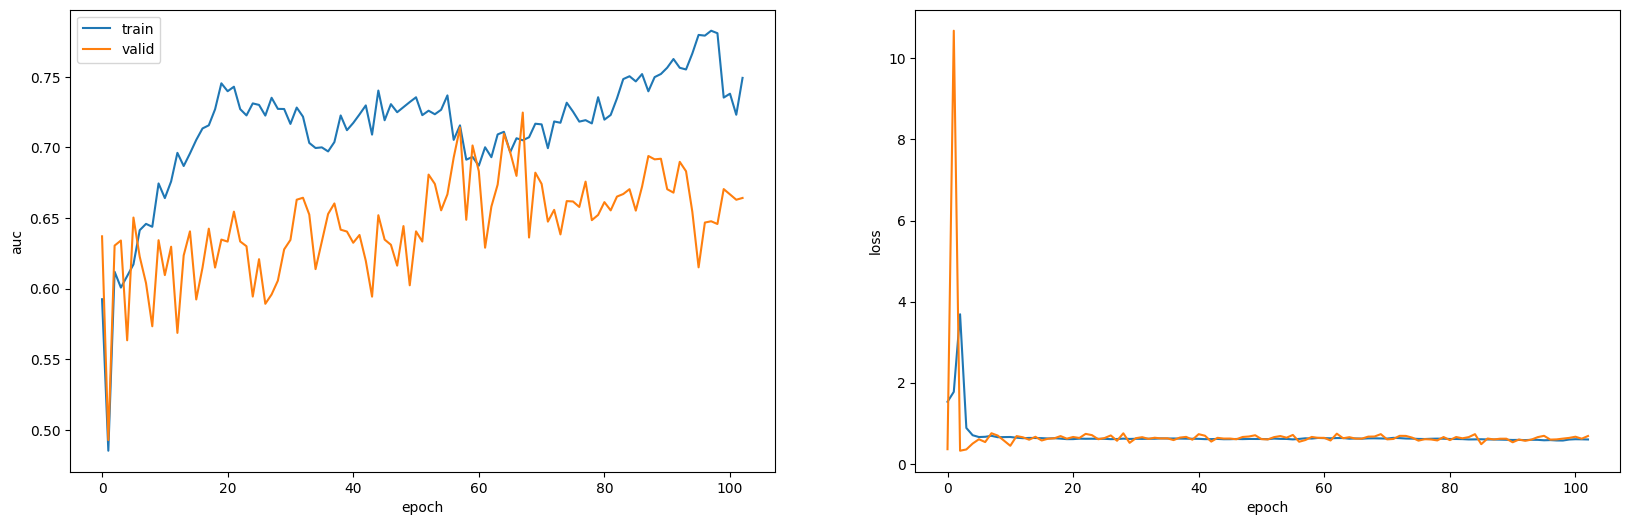

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
ax = axs[0]
ax.plot(clf.history['train_auc'], label="train")
ax.plot(clf.history['valid_auc'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('auc')
ax.legend()

ax = axs[1]
ax.plot(clf.history['loss'], label="train")
ax.plot(clf.history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

<Axes: xlabel='importances', ylabel='feature'>

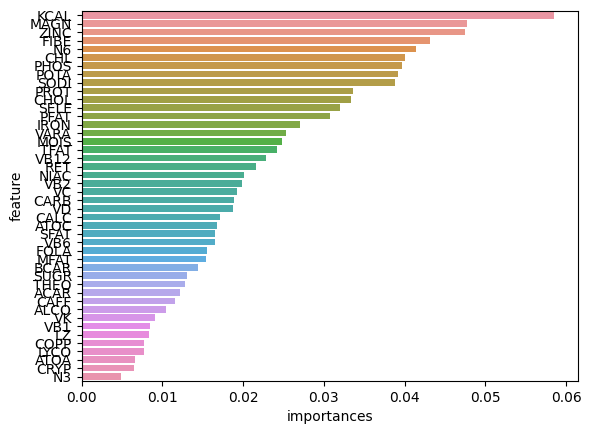

In [ ]:
def get_FI():
    importance = clf.feature_importances_
    feature = df.columns[1:]
    importances = pd.DataFrame()
    importances["feature"] = feature
    importances["importances"] = importance
    importances.sort_values("importances", ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)

    return importances

FI = get_FI()
sb.barplot(x="importances", y="feature", data=FI)

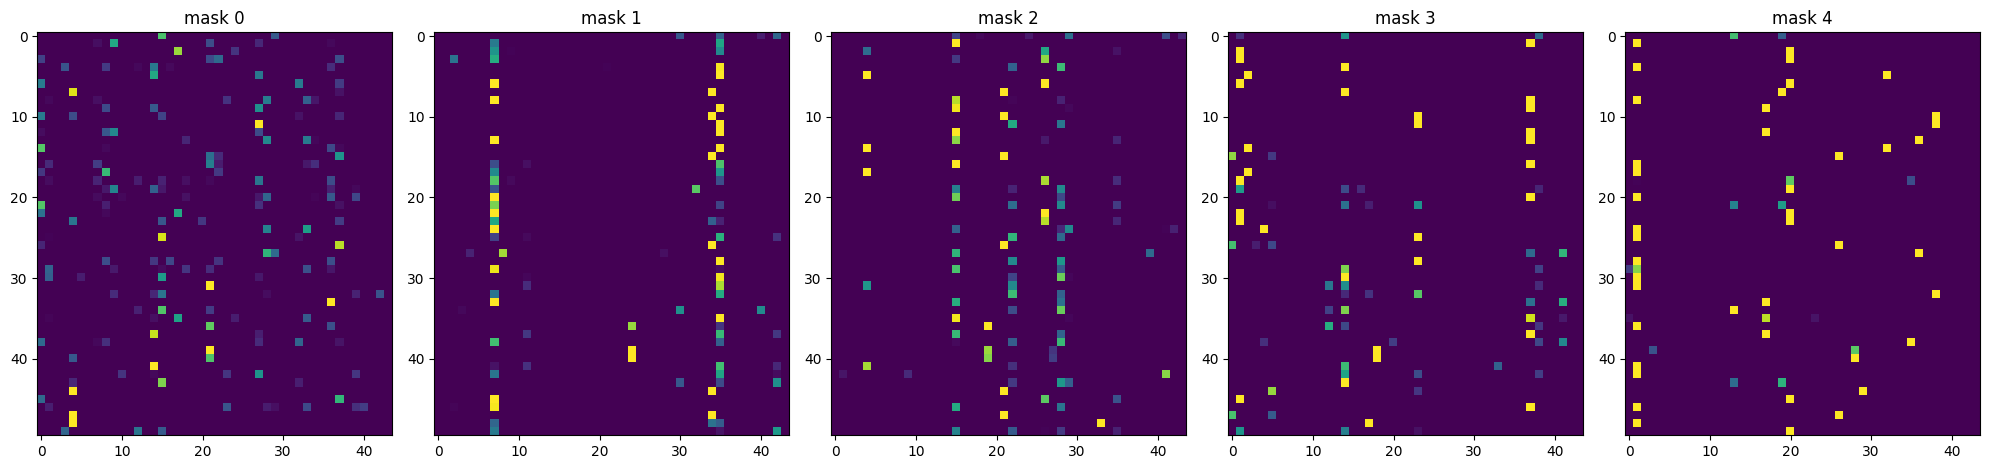

In [ ]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 5, figsize=(20,15))
for i in range(5):
    ax = axs[i]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
plt.tight_layout()

#### OB

In [ ]:
df = df_ob_us

In [ ]:
try:
  df.insert(0,"DC",0)
except:
  pass
df.loc[df['DC1'] == 1, 'DC'] = 1
df.loc[df['DC2'] == 1, 'DC'] = 1
df.loc[df['DC3'] == 1, 'DC'] = 1
df.loc[df['DC4'] == 1, 'DC'] = 1
df.loc[df['DC5'] == 1, 'DC'] = 1
df.loc[df['DC6'] == 1, 'DC'] = 1
df = df.drop(columns=[f"DC{i}" for i in range(1,6+1)])

In [ ]:
categorical_columns = ["DC"]
categorical_dims =  {}
for col in df.columns:
    if col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

DC 2


In [ ]:
df.to_csv("UsObDataset.csv")

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=11,
    gamma=1.5, n_independent=2, n_shared=2,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 1000
Hist = {}
Score = {}
for i in range(5):
  print(f"{i+1} Cycle")

  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss', 'accuracy', 'auc'],
      max_epochs=max_epochs , patience=300,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  preds = clf.predict_proba(X_test)

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  acc = accuracy_score(y_pred=y_pred, y_true=y_test)
  prec = precision_score(y_pred=y_pred, y_true=y_test, average="weighted")
  rec = recall_score(y_pred=y_pred, y_true=y_test, average="weighted")

  Hist[i] = clf.history
  Score[i] = [test_acc, acc, prec, rec]

1 Cycle
epoch 0  | loss: 1.91452 | train_logloss: 3.29849 | train_accuracy: 0.7081  | train_auc: 0.52185 | valid_logloss: 3.13315 | valid_accuracy: 0.7207  | valid_auc: 0.46242 |  0:00:05s
epoch 1  | loss: 1.35444 | train_logloss: 6.42023 | train_accuracy: 0.41822 | train_auc: 0.51002 | valid_logloss: 6.51012 | valid_accuracy: 0.40524 | valid_auc: 0.52625 |  0:00:10s
epoch 2  | loss: 1.39774 | train_logloss: 4.18976 | train_accuracy: 0.54595 | train_auc: 0.51189 | valid_logloss: 4.03556 | valid_accuracy: 0.57357 | valid_auc: 0.5068  |  0:00:16s
epoch 3  | loss: 3.48166 | train_logloss: 1.89002 | train_accuracy: 0.78442 | train_auc: 0.51404 | valid_logloss: 1.68818 | valid_accuracy: 0.80175 | valid_auc: 0.50758 |  0:00:22s
epoch 4  | loss: 2.30798 | train_logloss: 5.46089 | train_accuracy: 0.35997 | train_auc: 0.50394 | valid_logloss: 5.68388 | valid_accuracy: 0.34788 | valid_auc: 0.52343 |  0:00:27s
epoch 5  | loss: 1.75667 | train_logloss: 1.04717 | train_accuracy: 0.92461 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


2 Cycle
epoch 0  | loss: 1.73378 | train_logloss: 9.48942 | train_accuracy: 0.30997 | train_auc: 0.50465 | valid_logloss: 9.62015 | valid_accuracy: 0.3005  | valid_auc: 0.50465 |  0:00:04s
epoch 1  | loss: 1.31243 | train_logloss: 4.81633 | train_accuracy: 0.52804 | train_auc: 0.48717 | valid_logloss: 4.81245 | valid_accuracy: 0.54988 | valid_auc: 0.53077 |  0:00:10s
epoch 2  | loss: 1.42406 | train_logloss: 5.25863 | train_accuracy: 0.45748 | train_auc: 0.52123 | valid_logloss: 5.47549 | valid_accuracy: 0.42893 | valid_auc: 0.48674 |  0:00:16s
epoch 3  | loss: 1.14656 | train_logloss: 2.73925 | train_accuracy: 0.55047 | train_auc: 0.52698 | valid_logloss: 2.77024 | valid_accuracy: 0.53491 | valid_auc: 0.56033 |  0:00:21s
epoch 4  | loss: 0.98723 | train_logloss: 1.18892 | train_accuracy: 0.77134 | train_auc: 0.50945 | valid_logloss: 1.29944 | valid_accuracy: 0.76808 | valid_auc: 0.46748 |  0:00:26s
epoch 5  | loss: 1.12483 | train_logloss: 0.80895 | train_accuracy: 0.87975 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


3 Cycle
epoch 0  | loss: 2.11319 | train_logloss: 1.67558 | train_accuracy: 0.87056 | train_auc: 0.50991 | valid_logloss: 1.69632 | valid_accuracy: 0.86534 | valid_auc: 0.54781 |  0:00:06s
epoch 1  | loss: 1.80276 | train_logloss: 2.72423 | train_accuracy: 0.72477 | train_auc: 0.50046 | valid_logloss: 2.60959 | valid_accuracy: 0.73691 | valid_auc: 0.51519 |  0:00:11s
epoch 2  | loss: 1.35686 | train_logloss: 3.82925 | train_accuracy: 0.52103 | train_auc: 0.49653 | valid_logloss: 3.6122  | valid_accuracy: 0.54863 | valid_auc: 0.6111  |  0:00:17s
epoch 3  | loss: 1.18222 | train_logloss: 2.33203 | train_accuracy: 0.69019 | train_auc: 0.49753 | valid_logloss: 2.27231 | valid_accuracy: 0.69202 | valid_auc: 0.53729 |  0:00:23s
epoch 4  | loss: 1.1138  | train_logloss: 9.54841 | train_accuracy: 0.08925 | train_auc: 0.50398 | valid_logloss: 9.64902 | valid_accuracy: 0.09227 | valid_auc: 0.38027 |  0:00:28s
epoch 5  | loss: 1.95227 | train_logloss: 0.61358 | train_accuracy: 0.91184 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


4 Cycle
epoch 0  | loss: 1.93535 | train_logloss: 3.16998 | train_accuracy: 0.7257  | train_auc: 0.50884 | valid_logloss: 3.28429 | valid_accuracy: 0.72444 | valid_auc: 0.49645 |  0:00:06s
epoch 1  | loss: 1.68652 | train_logloss: 1.64116 | train_accuracy: 0.82243 | train_auc: 0.52539 | valid_logloss: 1.81787 | valid_accuracy: 0.81047 | valid_auc: 0.50249 |  0:00:12s
epoch 2  | loss: 1.66673 | train_logloss: 1.1336  | train_accuracy: 0.90748 | train_auc: 0.53858 | valid_logloss: 1.21232 | valid_accuracy: 0.90025 | valid_auc: 0.54726 |  0:00:17s
epoch 3  | loss: 2.31047 | train_logloss: 8.19474 | train_accuracy: 0.21854 | train_auc: 0.50807 | valid_logloss: 8.14186 | valid_accuracy: 0.22444 | valid_auc: 0.51411 |  0:00:23s
epoch 4  | loss: 2.18964 | train_logloss: 1.10305 | train_accuracy: 0.89891 | train_auc: 0.52688 | valid_logloss: 1.01844 | valid_accuracy: 0.90399 | valid_auc: 0.61602 |  0:00:29s
epoch 5  | loss: 2.94143 | train_logloss: 1.7632  | train_accuracy: 0.71916 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


5 Cycle
epoch 0  | loss: 1.9316  | train_logloss: 3.47303 | train_accuracy: 0.68863 | train_auc: 0.51496 | valid_logloss: 3.58261 | valid_accuracy: 0.69451 | valid_auc: 0.55727 |  0:00:07s
epoch 1  | loss: 1.46546 | train_logloss: 9.16159 | train_accuracy: 0.25701 | train_auc: 0.4802  | valid_logloss: 9.61188 | valid_accuracy: 0.24065 | valid_auc: 0.51553 |  0:00:14s
epoch 2  | loss: 1.4419  | train_logloss: 1.1709  | train_accuracy: 0.87944 | train_auc: 0.52727 | valid_logloss: 1.22783 | valid_accuracy: 0.87905 | valid_auc: 0.54094 |  0:00:19s
epoch 3  | loss: 1.67237 | train_logloss: 8.91655 | train_accuracy: 0.16495 | train_auc: 0.47236 | valid_logloss: 9.11353 | valid_accuracy: 0.17456 | valid_auc: 0.46799 |  0:00:24s
epoch 4  | loss: 1.41147 | train_logloss: 6.16803 | train_accuracy: 0.30374 | train_auc: 0.47143 | valid_logloss: 6.54904 | valid_accuracy: 0.29177 | valid_auc: 0.49925 |  0:00:31s
epoch 5  | loss: 1.46953 | train_logloss: 2.00524 | train_accuracy: 0.65841 | train_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
a = "UsOb"
with open(f'{a}Hist.pkl', 'wb') as file_pi:
      pickle.dump(Hist, file_pi)
with open(f'{a}Score.pkl', 'wb') as file_pi:
      pickle.dump(Score, file_pi)

In [ ]:
a=0
test_acc = 0
while a < 200:
  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  max_epochs = 1000

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['accuracy', 'auc', 'logloss'],
      max_epochs=max_epochs , patience=100,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  a = len(clf.history["loss"])

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

  preds = clf.predict_proba(X_test)
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  print(test_acc)

epoch 0  | loss: 2.63294 | train_accuracy: 0.83442 | train_auc: 0.49555 | train_logloss: 2.1696  | valid_accuracy: 0.84663 | valid_auc: 0.56399 | valid_logloss: 1.87783 |  0:00:06s
epoch 1  | loss: 2.07614 | train_accuracy: 0.74751 | train_auc: 0.51182 | train_logloss: 2.91942 | valid_accuracy: 0.76683 | valid_auc: 0.51131 | valid_logloss: 2.49325 |  0:00:15s
epoch 2  | loss: 1.84153 | train_accuracy: 0.70545 | train_auc: 0.5166  | train_logloss: 2.9258  | valid_accuracy: 0.71571 | valid_auc: 0.55144 | valid_logloss: 2.65015 |  0:00:21s
epoch 3  | loss: 1.62087 | train_accuracy: 0.66153 | train_auc: 0.52473 | train_logloss: 3.16665 | valid_accuracy: 0.66459 | valid_auc: 0.53632 | valid_logloss: 3.23272 |  0:00:25s
epoch 4  | loss: 1.54714 | train_accuracy: 0.62087 | train_auc: 0.51742 | train_logloss: 2.86963 | valid_accuracy: 0.64464 | valid_auc: 0.52416 | valid_logloss: 2.71132 |  0:00:31s
epoch 5  | loss: 1.53578 | train_accuracy: 0.5824  | train_auc: 0.51391 | train_logloss: 3.163 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.8839167991512853


In [ ]:
# saved_filename = clf.save_model('test_model_ob_us_2')

loaded_clf = TabNetClassifier()
loaded_clf.load_model('test_model_ob_us_2.zip')

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = f1_score(y_pred=loaded_y_pred, y_true=y_test, average="weighted")

print(f"FINAL TEST SCORE : {loaded_test_acc}")

assert(test_acc == loaded_test_acc)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


FINAL TEST SCORE : 0.9004524997295413


AssertionError: ignored

In [ ]:
dataset = {
    "X_train":X_train,
    "X_test":X_test,
    "X_valid":X_valid,
    "y_train":y_train,
    "y_test":y_test,
    "y_valid":y_valid
}

with open('UsObdataset_2.pkl', 'wb') as file_pi:
        pickle.dump(dataset, file_pi)

In [ ]:
with open('ObUsHistory_2.pkl', 'wb') as file_pi:
        pickle.dump(clf.history, file_pi)

In [ ]:
dataset = pickle.load(open('UsObdataset.pkl', "rb"))
X_train = dataset["X_train"]
y_train = dataset["y_train"]
X_valid = dataset["X_valid"]
y_valid = dataset["y_valid"]
X_test = dataset["X_test"]
y_test = dataset["y_test"]

In [ ]:
pred_proba_class1 = loaded_clf.predict_proba(X_test)[:, 1]
print('max predict_proba:', np.round(np.max(pred_proba_class1), 2))

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
print('thresholds[0](=max predict_proba+1):', np.round(thresholds[0], 2))

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

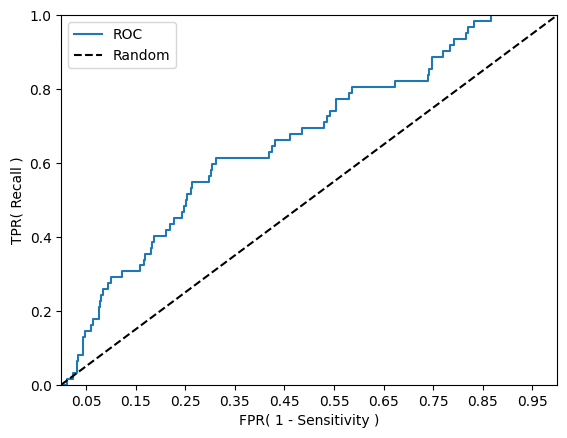

ROC AUC 값: 0.6608


In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

roc_curve_plot(y_test, loaded_clf.predict_proba(X_test)[:, 1] )

pred_proba = loaded_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

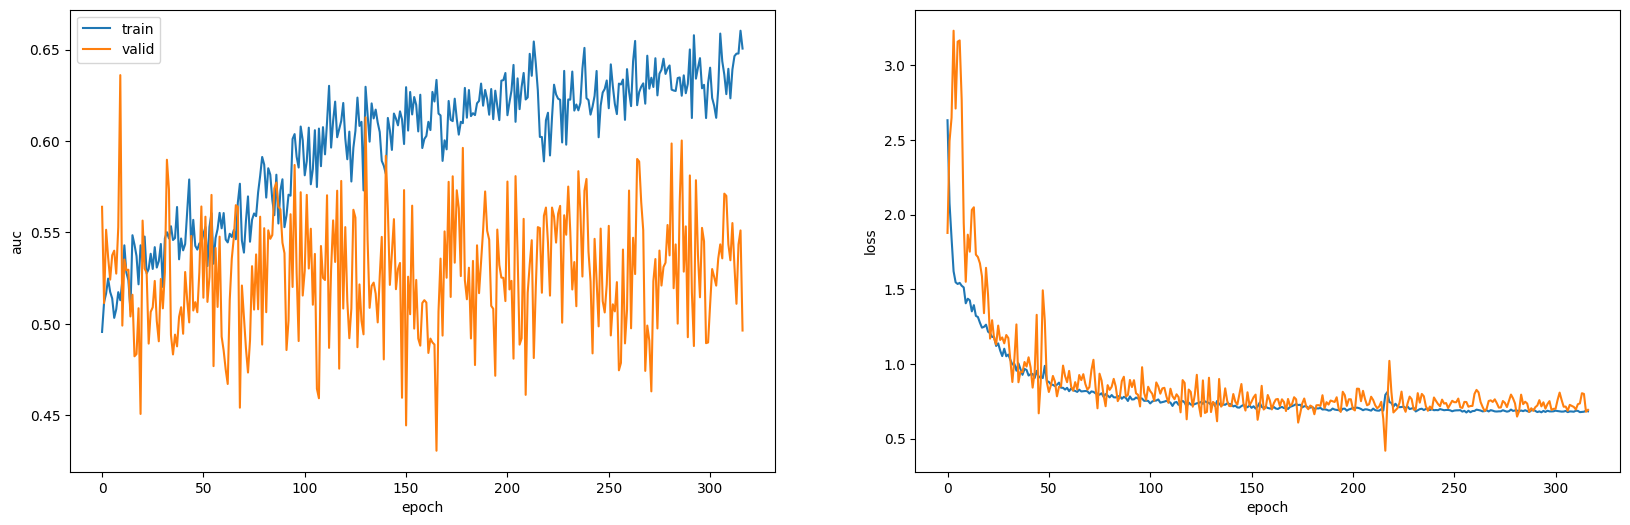

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
ax = axs[0]
ax.plot(clf.history['train_auc'], label="train")
ax.plot(clf.history['valid_auc'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('auc')
ax.legend()

ax = axs[1]
ax.plot(clf.history['loss'], label="train")
ax.plot(clf.history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

<Axes: xlabel='importances', ylabel='feature'>

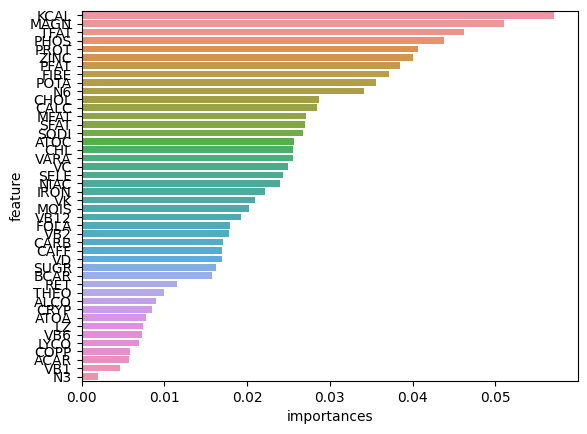

In [ ]:
def get_FI():
    importance = clf.feature_importances_
    feature = df.columns[1:]
    importances = pd.DataFrame()
    importances["feature"] = feature
    importances["importances"] = importance
    importances.sort_values("importances", ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)

    return importances

FI = get_FI()
sb.barplot(x="importances", y="feature", data=FI)

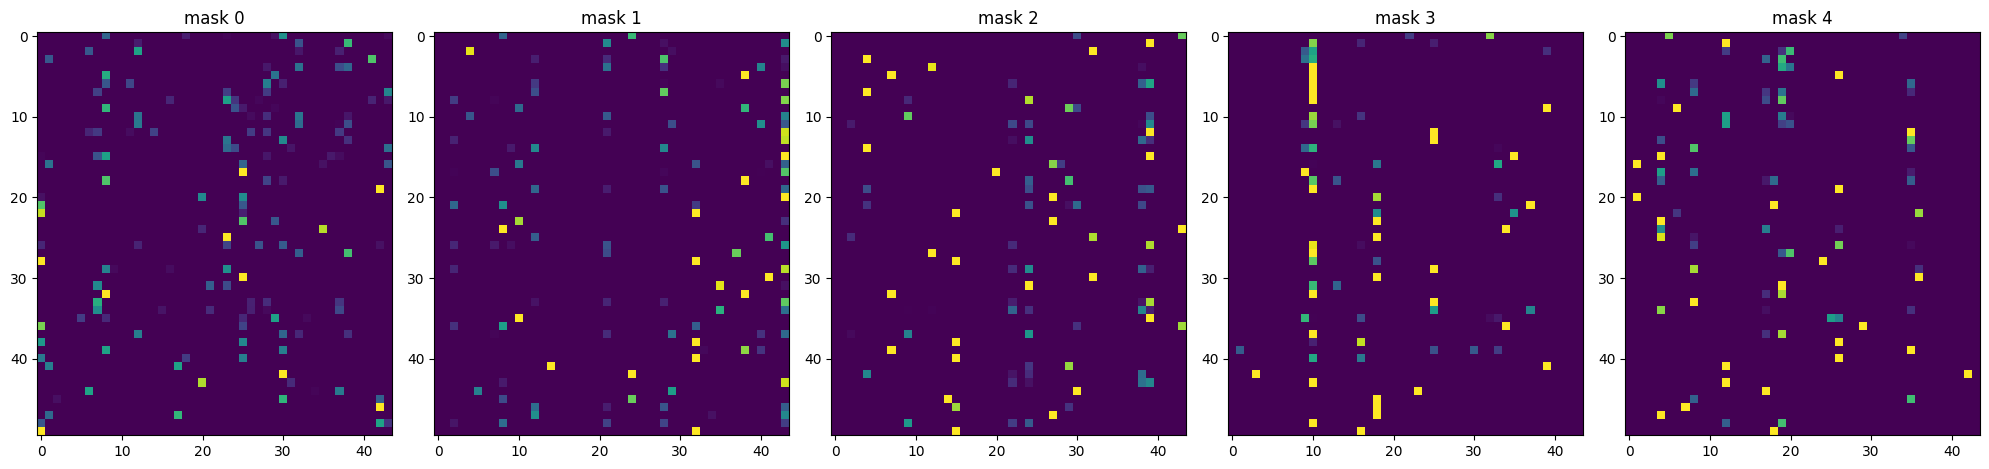

In [ ]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 5, figsize=(20,15))
for i in range(5):
    ax = axs[i]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
plt.tight_layout()

#### YBOB 분리 X

In [ ]:
df = pd.concat([df_yb_us, df_ob_us])

In [ ]:
try:
  df.insert(0,"DC",0)
except:
  pass
df.loc[df['DC1'] == 1, 'DC'] = 1
df.loc[df['DC2'] == 1, 'DC'] = 1
df.loc[df['DC3'] == 1, 'DC'] = 1
df.loc[df['DC4'] == 1, 'DC'] = 1
df.loc[df['DC5'] == 1, 'DC'] = 1
df.loc[df['DC6'] == 1, 'DC'] = 1
df = df.drop(columns=[f"DC{i}" for i in range(1,6+1)])

In [ ]:
print(df[df["DC"] == 0].shape)
print(df[df["DC"] != 0].shape)

In [ ]:
categorical_columns = ["DC"]
categorical_dims =  {}
for col in df.columns:
    if col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

In [ ]:
test_acc=0
while test_acc < 0.85:
  X = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

  max_epochs = 1000

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      # eval_metric=['balanced_accuracy'],
      max_epochs=max_epochs , patience=100,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

  preds = clf.predict_proba(X_test)
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
  test_acc = f1_score(y_pred=y_pred, y_true=y_test, average="weighted")
  print(test_acc)

In [ ]:
saved_filename = clf.save_model('test_model_ybob_us')

loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = f1_score(y_pred=loaded_y_pred, y_true=y_test, average="weighted")

print(f"FINAL TEST SCORE : {loaded_test_acc}")

assert(test_acc == loaded_test_acc)

In [ ]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['loss'])
plt.plot(clf.history['valid_auc'])
plt.xlabel('epoch')
plt.legend(['train_auc', 'loss'])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
ax = axs[0]
ax.plot(clf.history['train_auc'], label="train")
ax.plot(clf.history['valid_auc'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('auc')
ax.legend()

ax = axs[1]
ax.plot(clf.history['loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

In [ ]:
def get_FI():
    importance = clf.feature_importances_
    feature = df.columns[1:]
    importances = pd.DataFrame()
    importances["feature"] = feature
    importances["importances"] = importance
    importances.sort_values("importances", ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)

    return importances

FI = get_FI()
sb.barplot(x="importances", y="feature", data=FI)

In [ ]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(2, 5, figsize=(20,15))
for i in range(10):
  if i < 5:
    ax = axs[0, i]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
  else:
    ax = axs[1, i-5]
    ax.imshow(masks[i][:50])
    ax.set_title(f"mask {i}")
plt.tight_layout()

## 2

In [ ]:
h_ky = pickle.load(open('KrYbHist.pkl', "rb"))
s_ky = pickle.load(open('KrYbScore.pkl', "rb")) # [f1, acc, prec, rec]

h_ko = pickle.load(open('KrObHist.pkl', "rb"))
s_ko = pickle.load(open('KrObScore.pkl', "rb")) # [f1, acc, prec, rec]

h_uy = pickle.load(open('UsYbHist.pkl', "rb"))
s_uy = pickle.load(open('UsYbScore.pkl', "rb")) # [f1, acc, prec, rec]

h_uo = pickle.load(open('UsObHist.pkl', "rb"))
s_uo = pickle.load(open('UsObScore.pkl', "rb")) # [f1, acc, prec, rec]

NameError: ignored

In [ ]:
h_ky[0].history.keys()

dict_keys(['loss', 'lr', 'train_logloss', 'train_accuracy', 'train_auc', 'valid_logloss', 'valid_accuracy', 'valid_auc'])

In [ ]:
for i in range(0,5):
  print(max(h_ky[i]['valid_auc']))

0.6872203164923276
0.6883774465831596
0.6887205340572282
0.684858191524858
0.6999328219469138


In [ ]:
for i in range(0,5):
  print(max(h_ko[i]['valid_auc']))

0.6227026026890342
0.6530302144819122
0.6144438722966014
0.5989226006191951
0.5842168911887955


In [ ]:
for i in range(0,5):
  print(max(h_uy[i]['valid_auc']))

0.702005614092185
0.7253428437990914
0.6642828364222401
0.6319448698315466
0.7047715257433411


In [ ]:
for i in range(0,5):
  print(max(h_uo[i]['valid_auc']))

0.6178427805438529
0.630121293800539
0.6678148595934941
0.6160190733939043
0.6215791686024645


### history

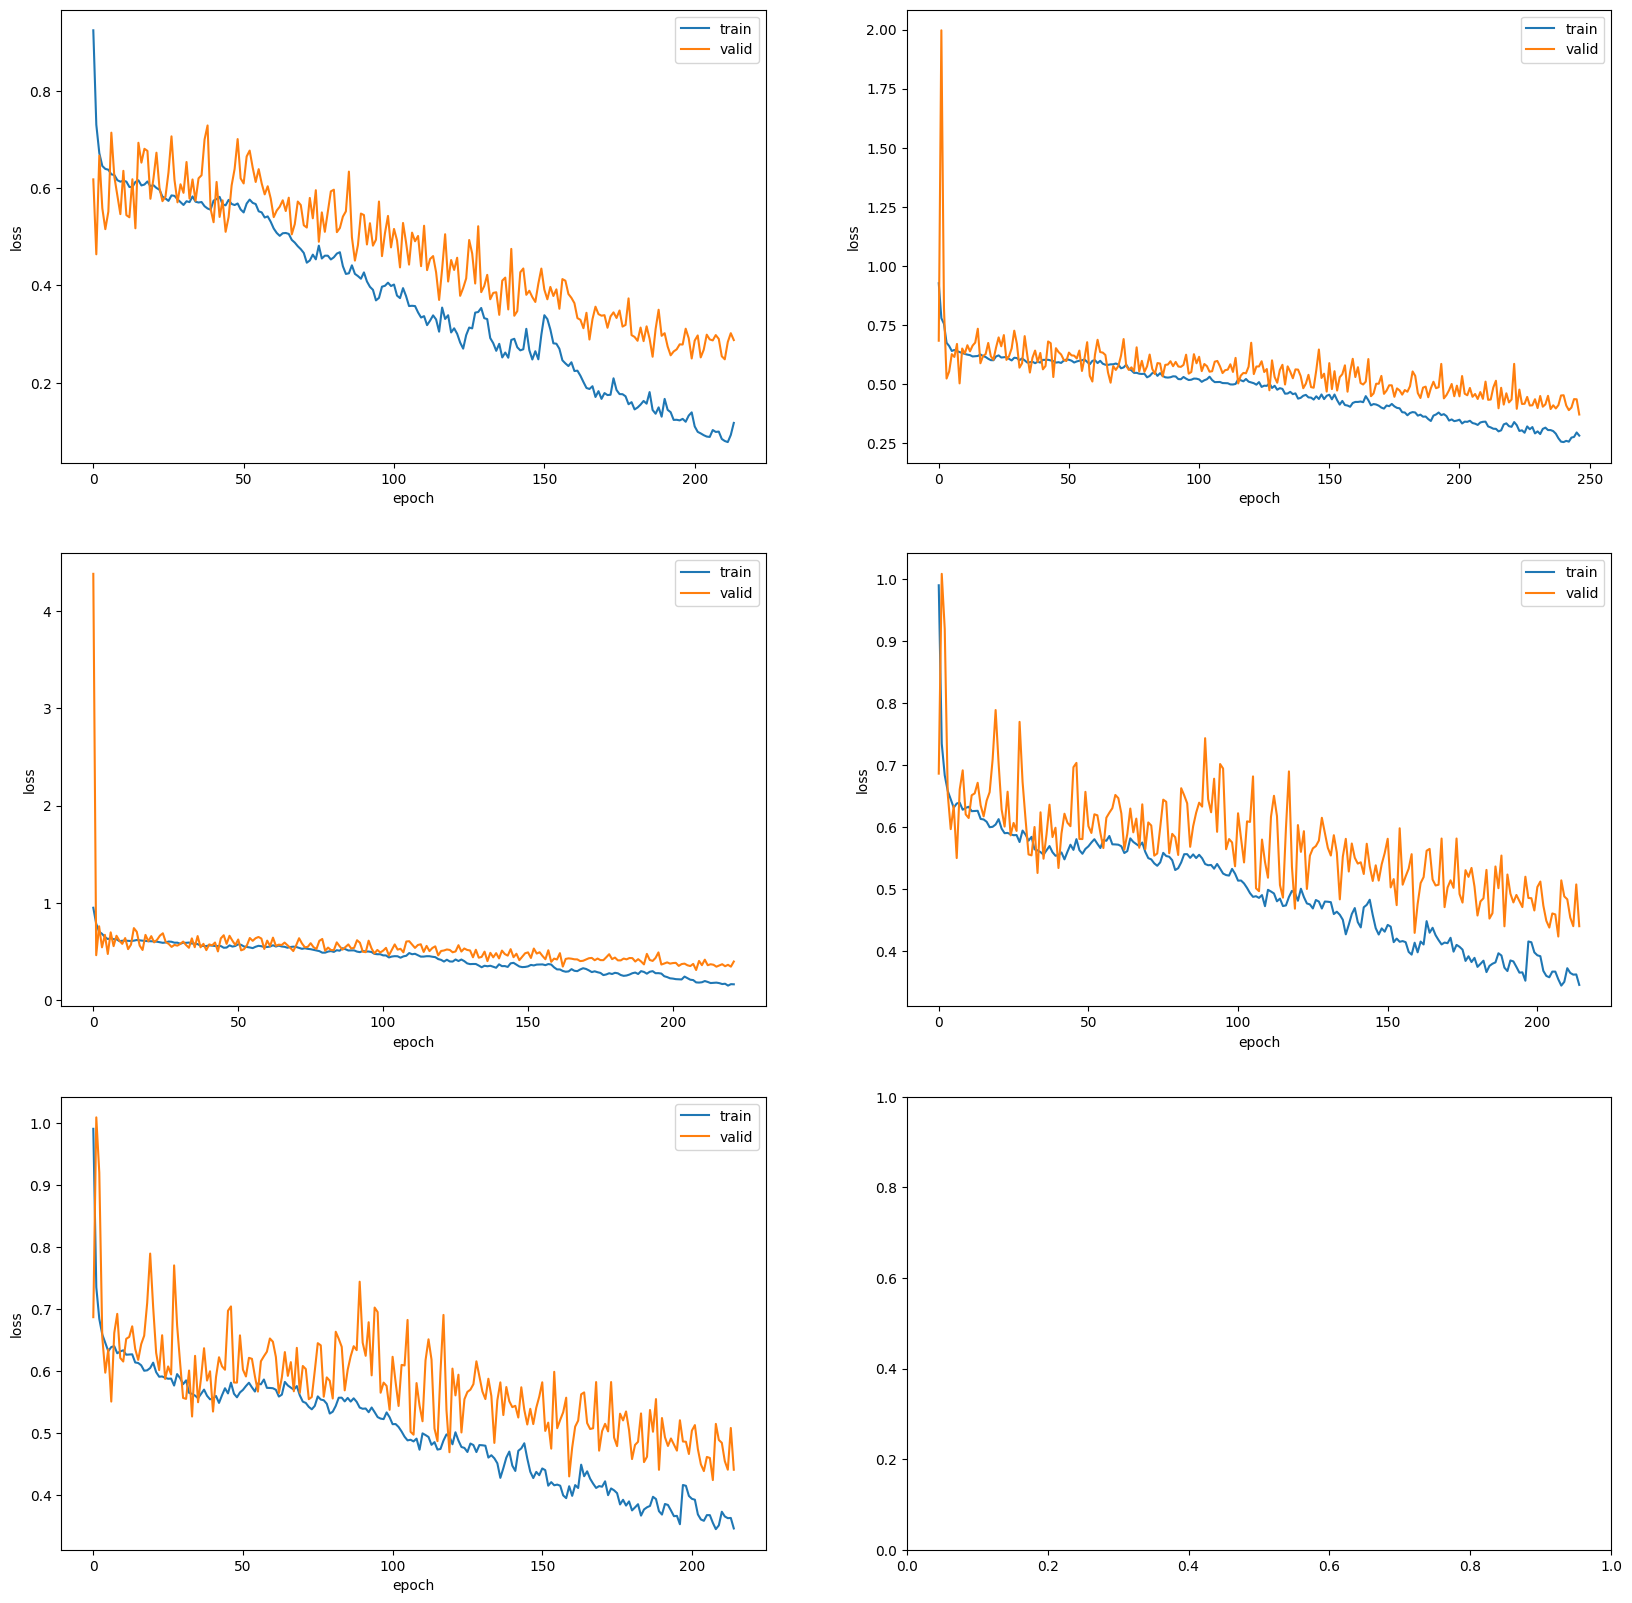

In [ ]:
a = h_ky

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history['loss'], label="train")
ax.plot(a[0].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history['loss'], label="train")
ax.plot(a[1].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history['loss'], label="train")
ax.plot(a[2].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history['loss'], label="train")
ax.plot(a[3].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history['loss'], label="train")
ax.plot(a[3].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

plt.show()

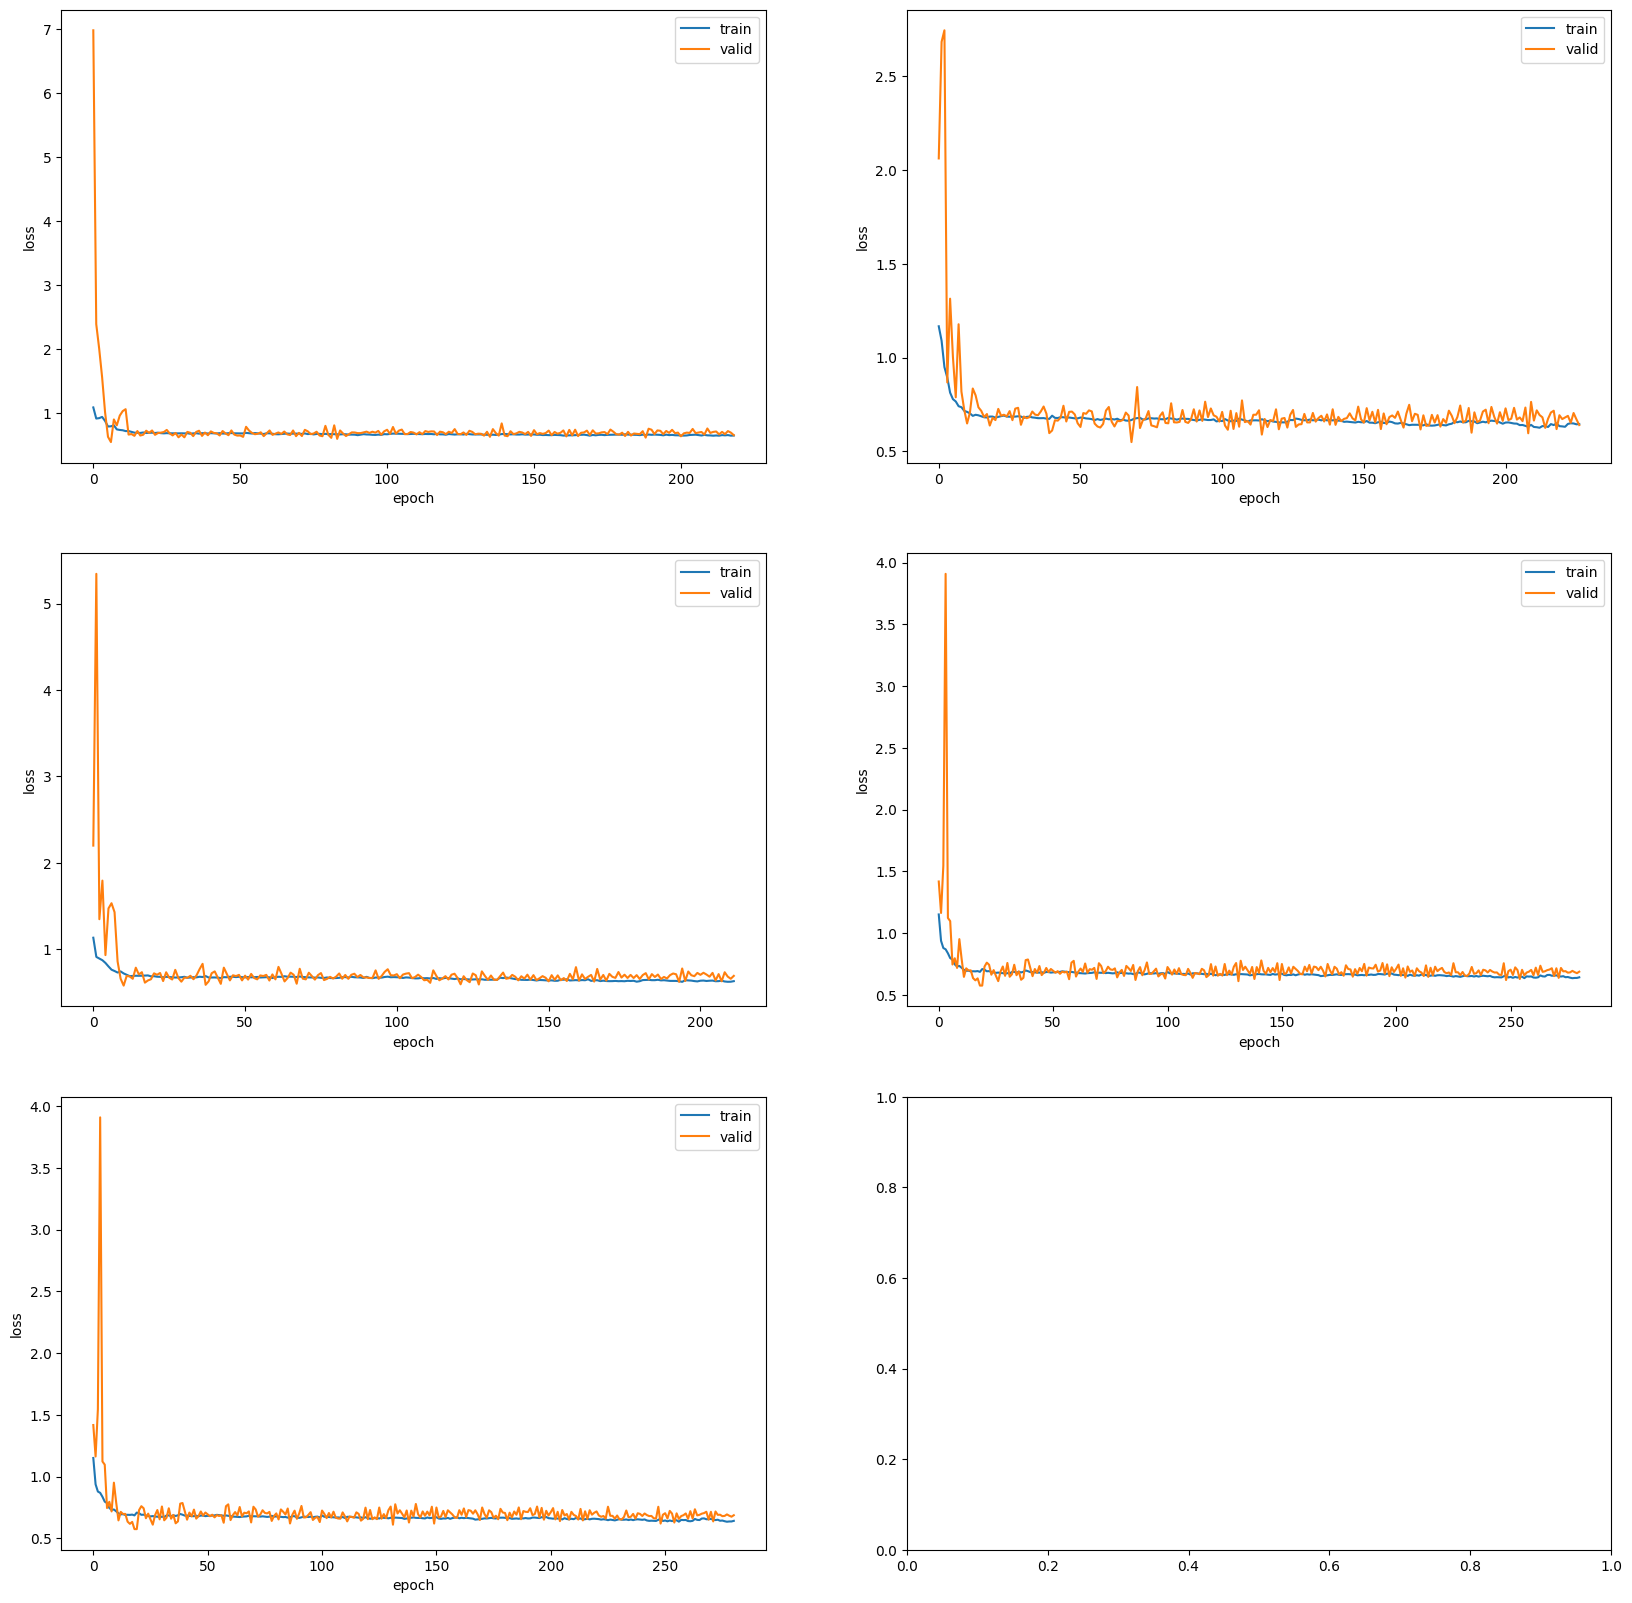

In [ ]:
a = h_ko

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history['loss'], label="train")
ax.plot(a[0].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history['loss'], label="train")
ax.plot(a[1].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history['loss'], label="train")
ax.plot(a[2].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history['loss'], label="train")
ax.plot(a[3].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history['loss'], label="train")
ax.plot(a[3].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

plt.show()

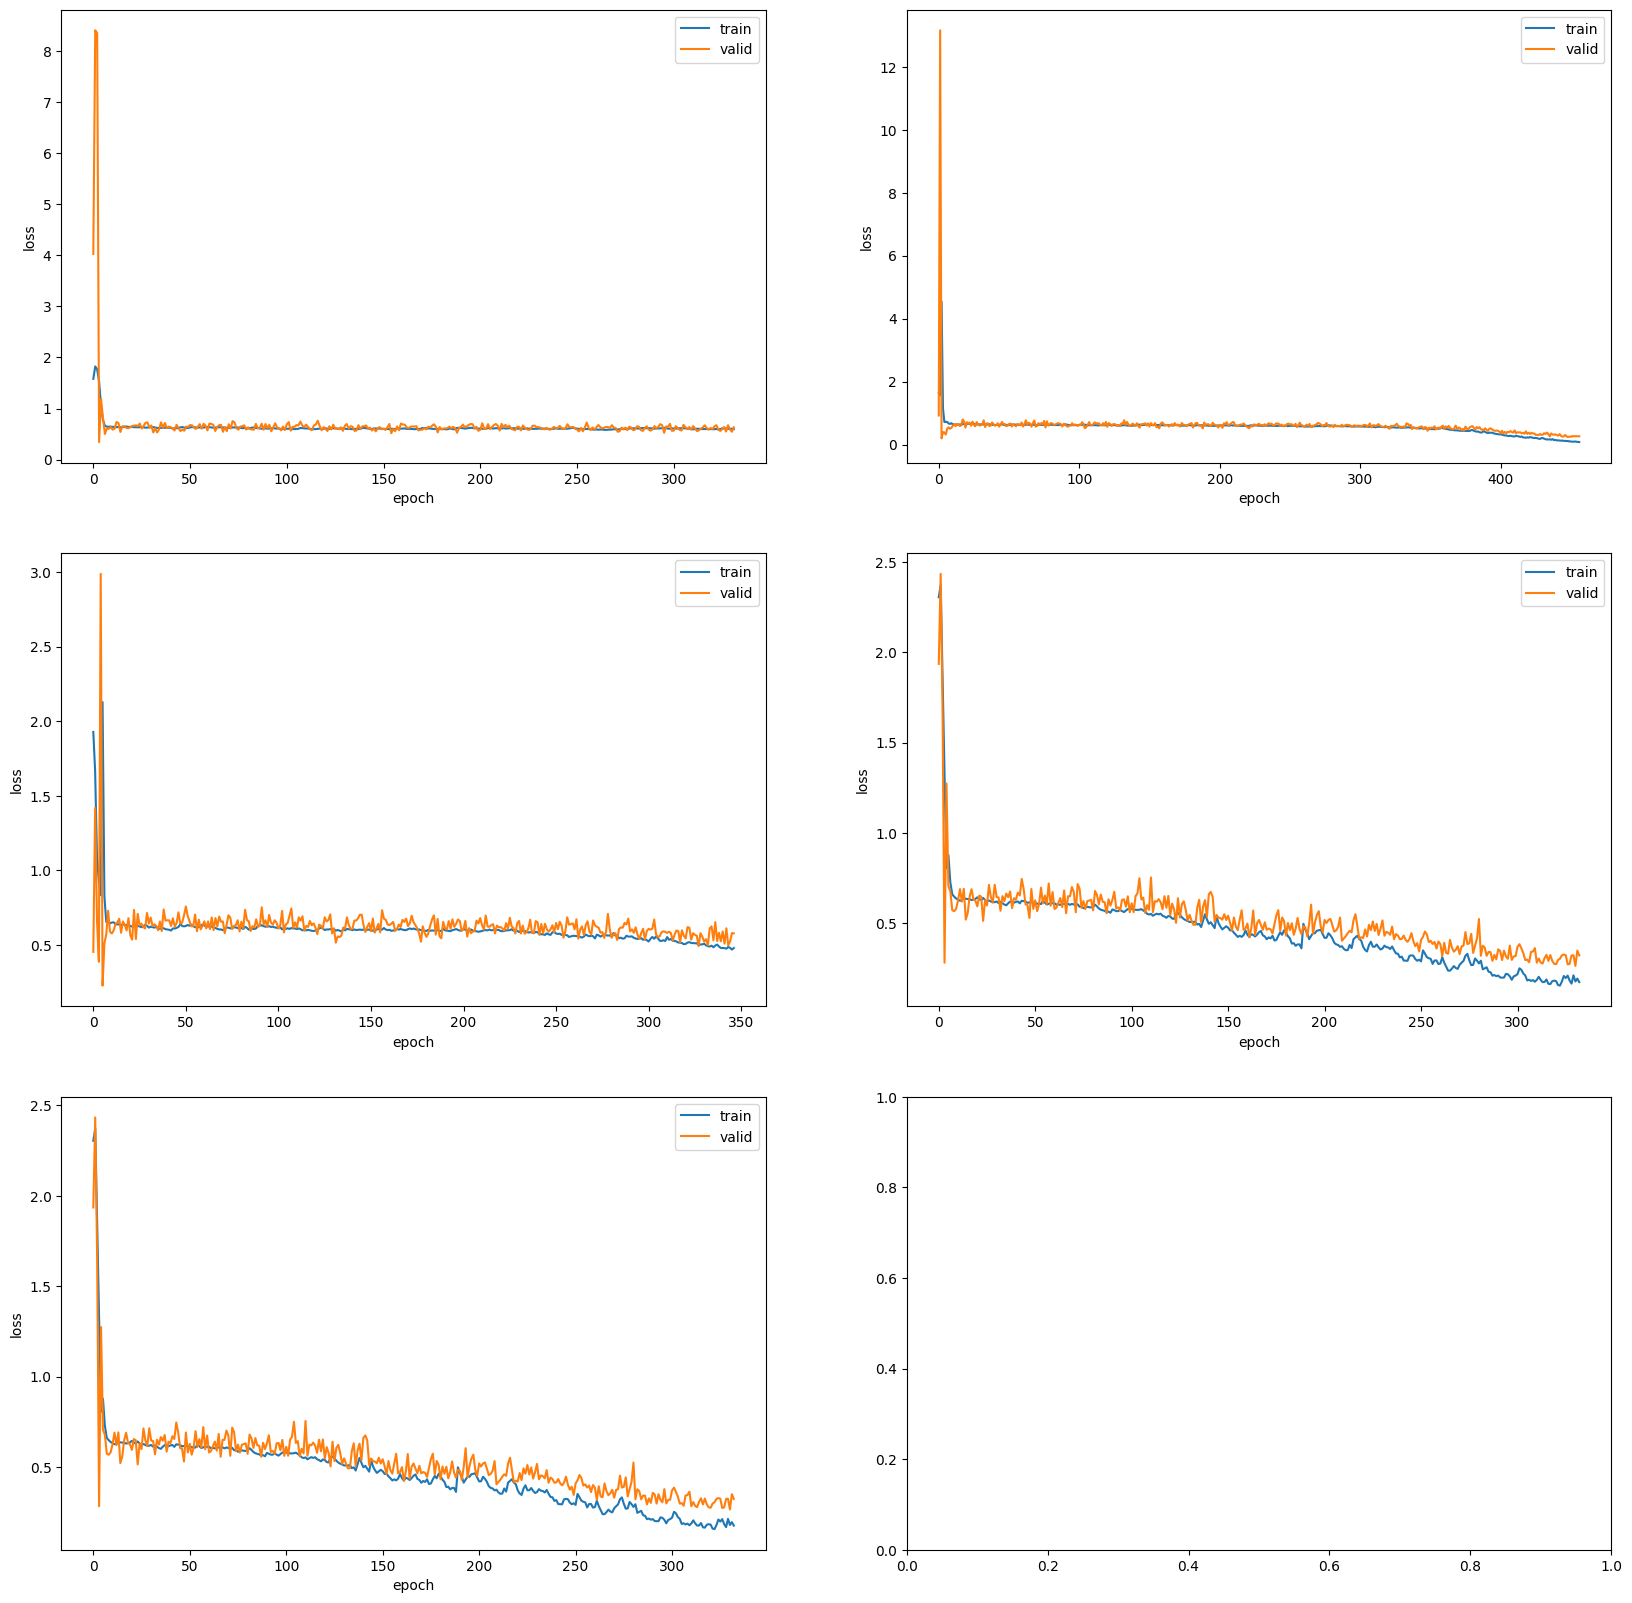

In [ ]:
a = h_uy

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history['loss'], label="train")
ax.plot(a[0].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history['loss'], label="train")
ax.plot(a[1].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history['loss'], label="train")
ax.plot(a[2].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history['loss'], label="train")
ax.plot(a[3].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history['loss'], label="train")
ax.plot(a[3].history['valid_logloss'], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

plt.show()

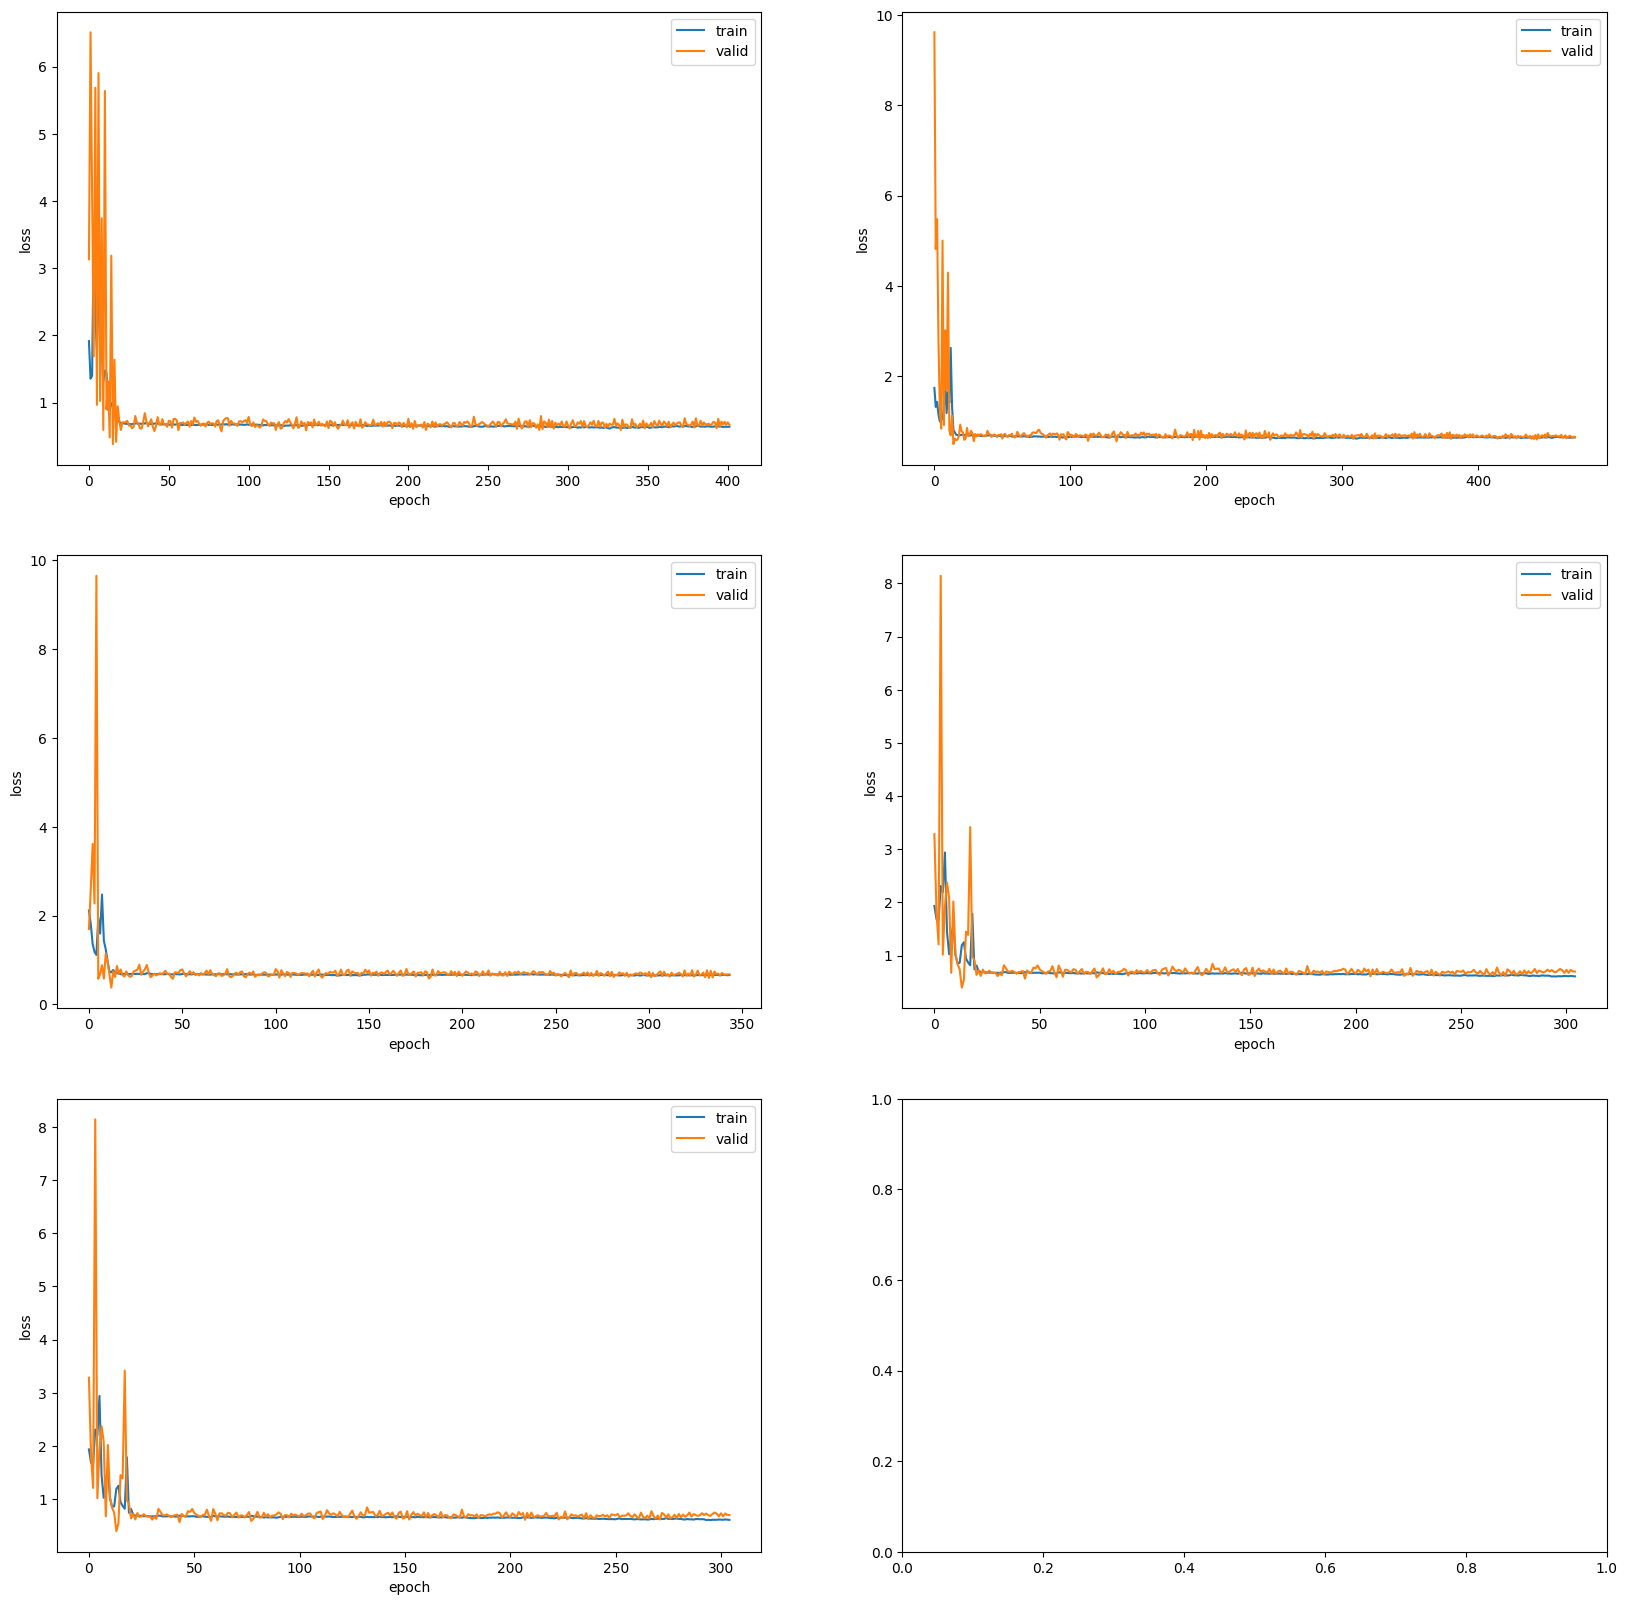

In [ ]:
a = h_uo
t = "loss"
v = "valid_logloss"
yl = "loss"

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history[t], label="train")
ax.plot(a[0].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history[t], label="train")
ax.plot(a[1].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history[t], label="train")
ax.plot(a[2].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

plt.show()

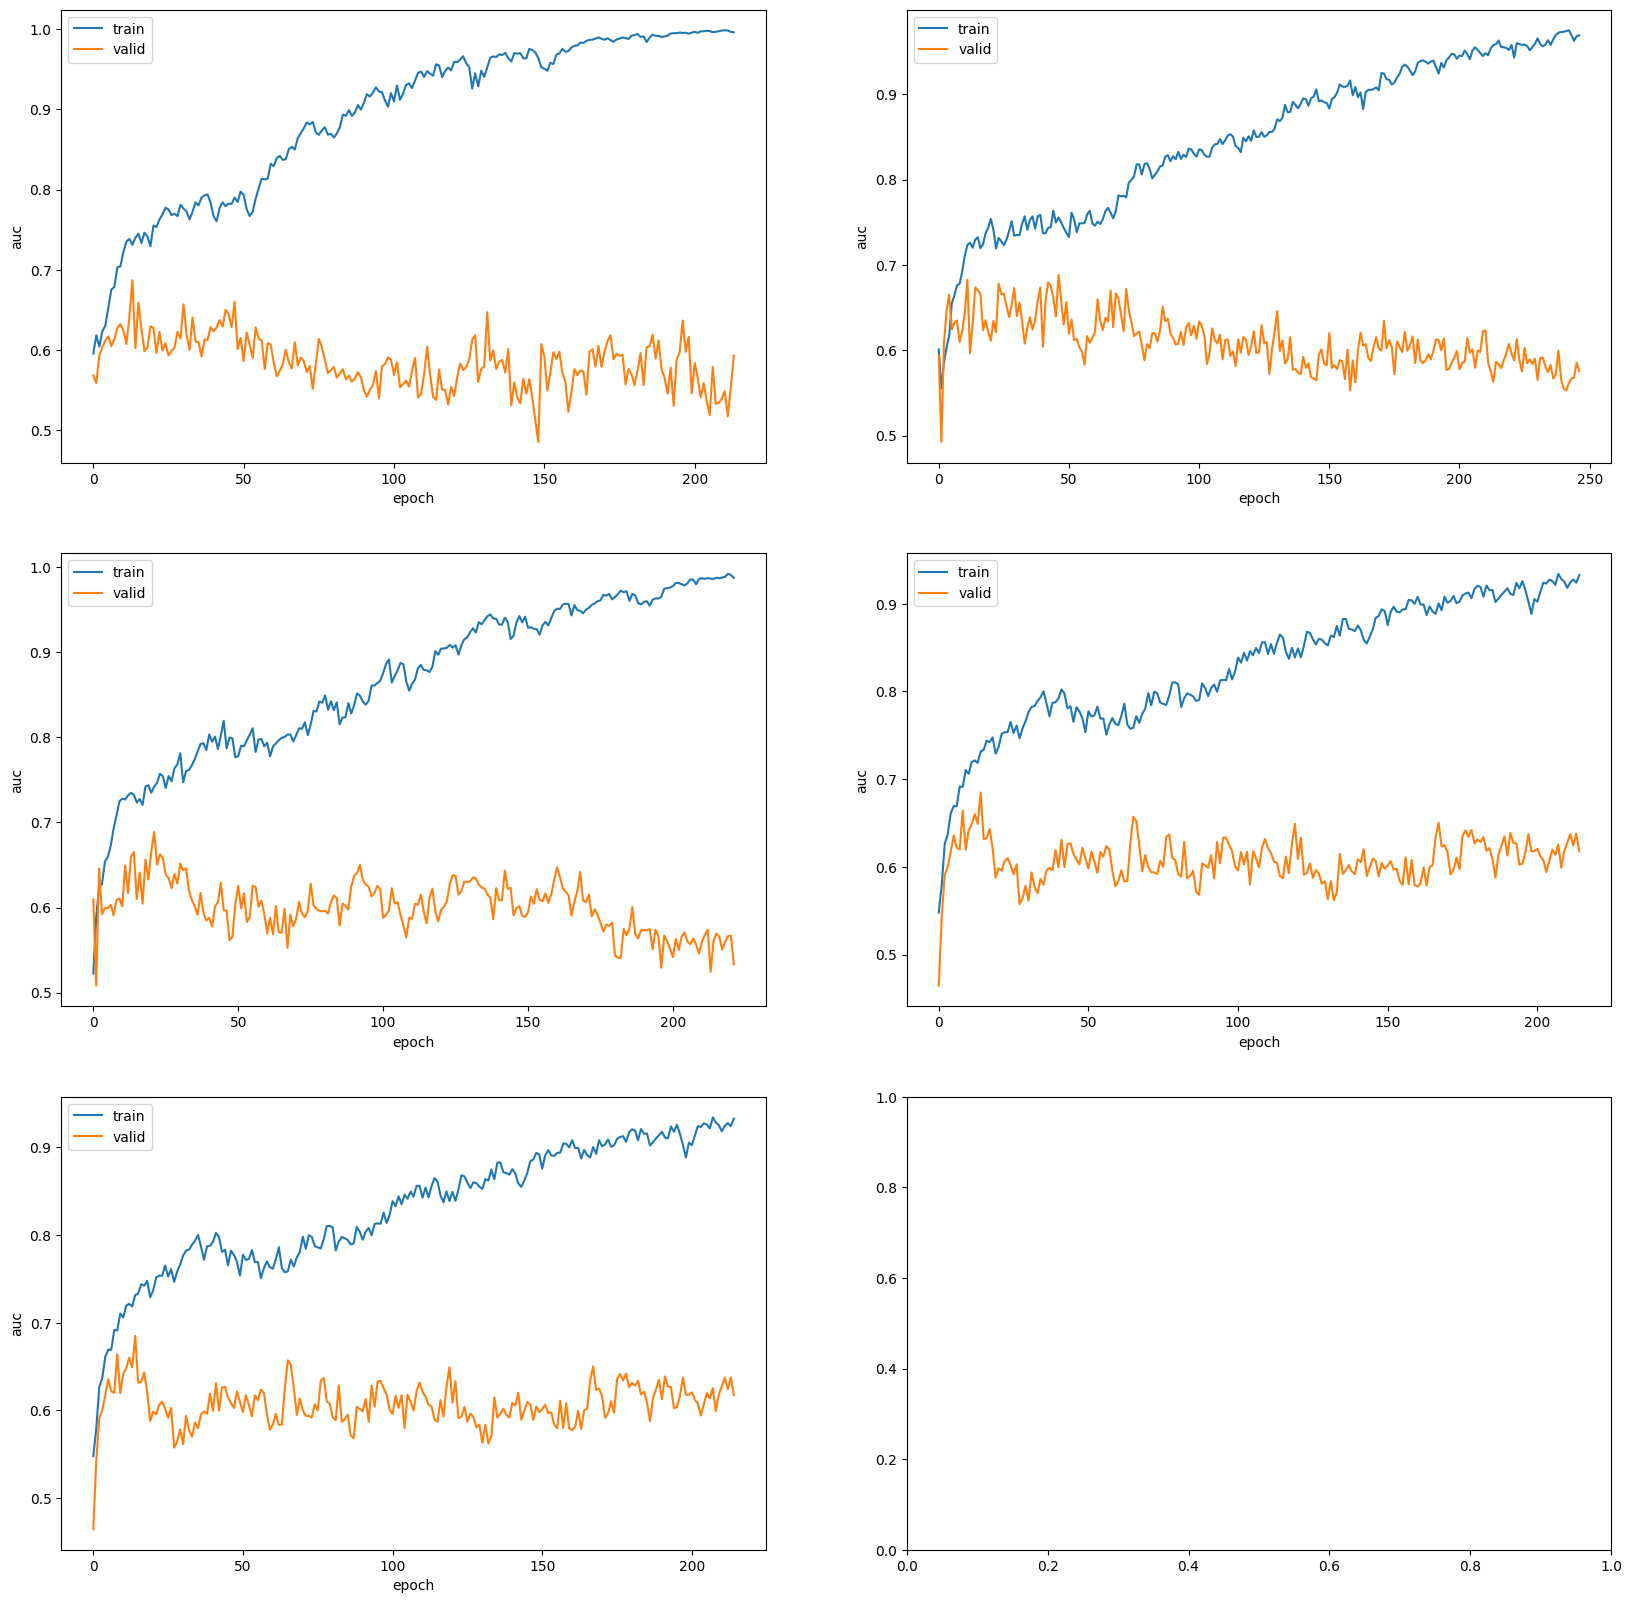

In [ ]:
a = h_ky
t = "train_auc"
v = "valid_auc"
yl = "auc"

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history[t], label="train")
ax.plot(a[0].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history[t], label="train")
ax.plot(a[1].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history[t], label="train")
ax.plot(a[2].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

plt.show()

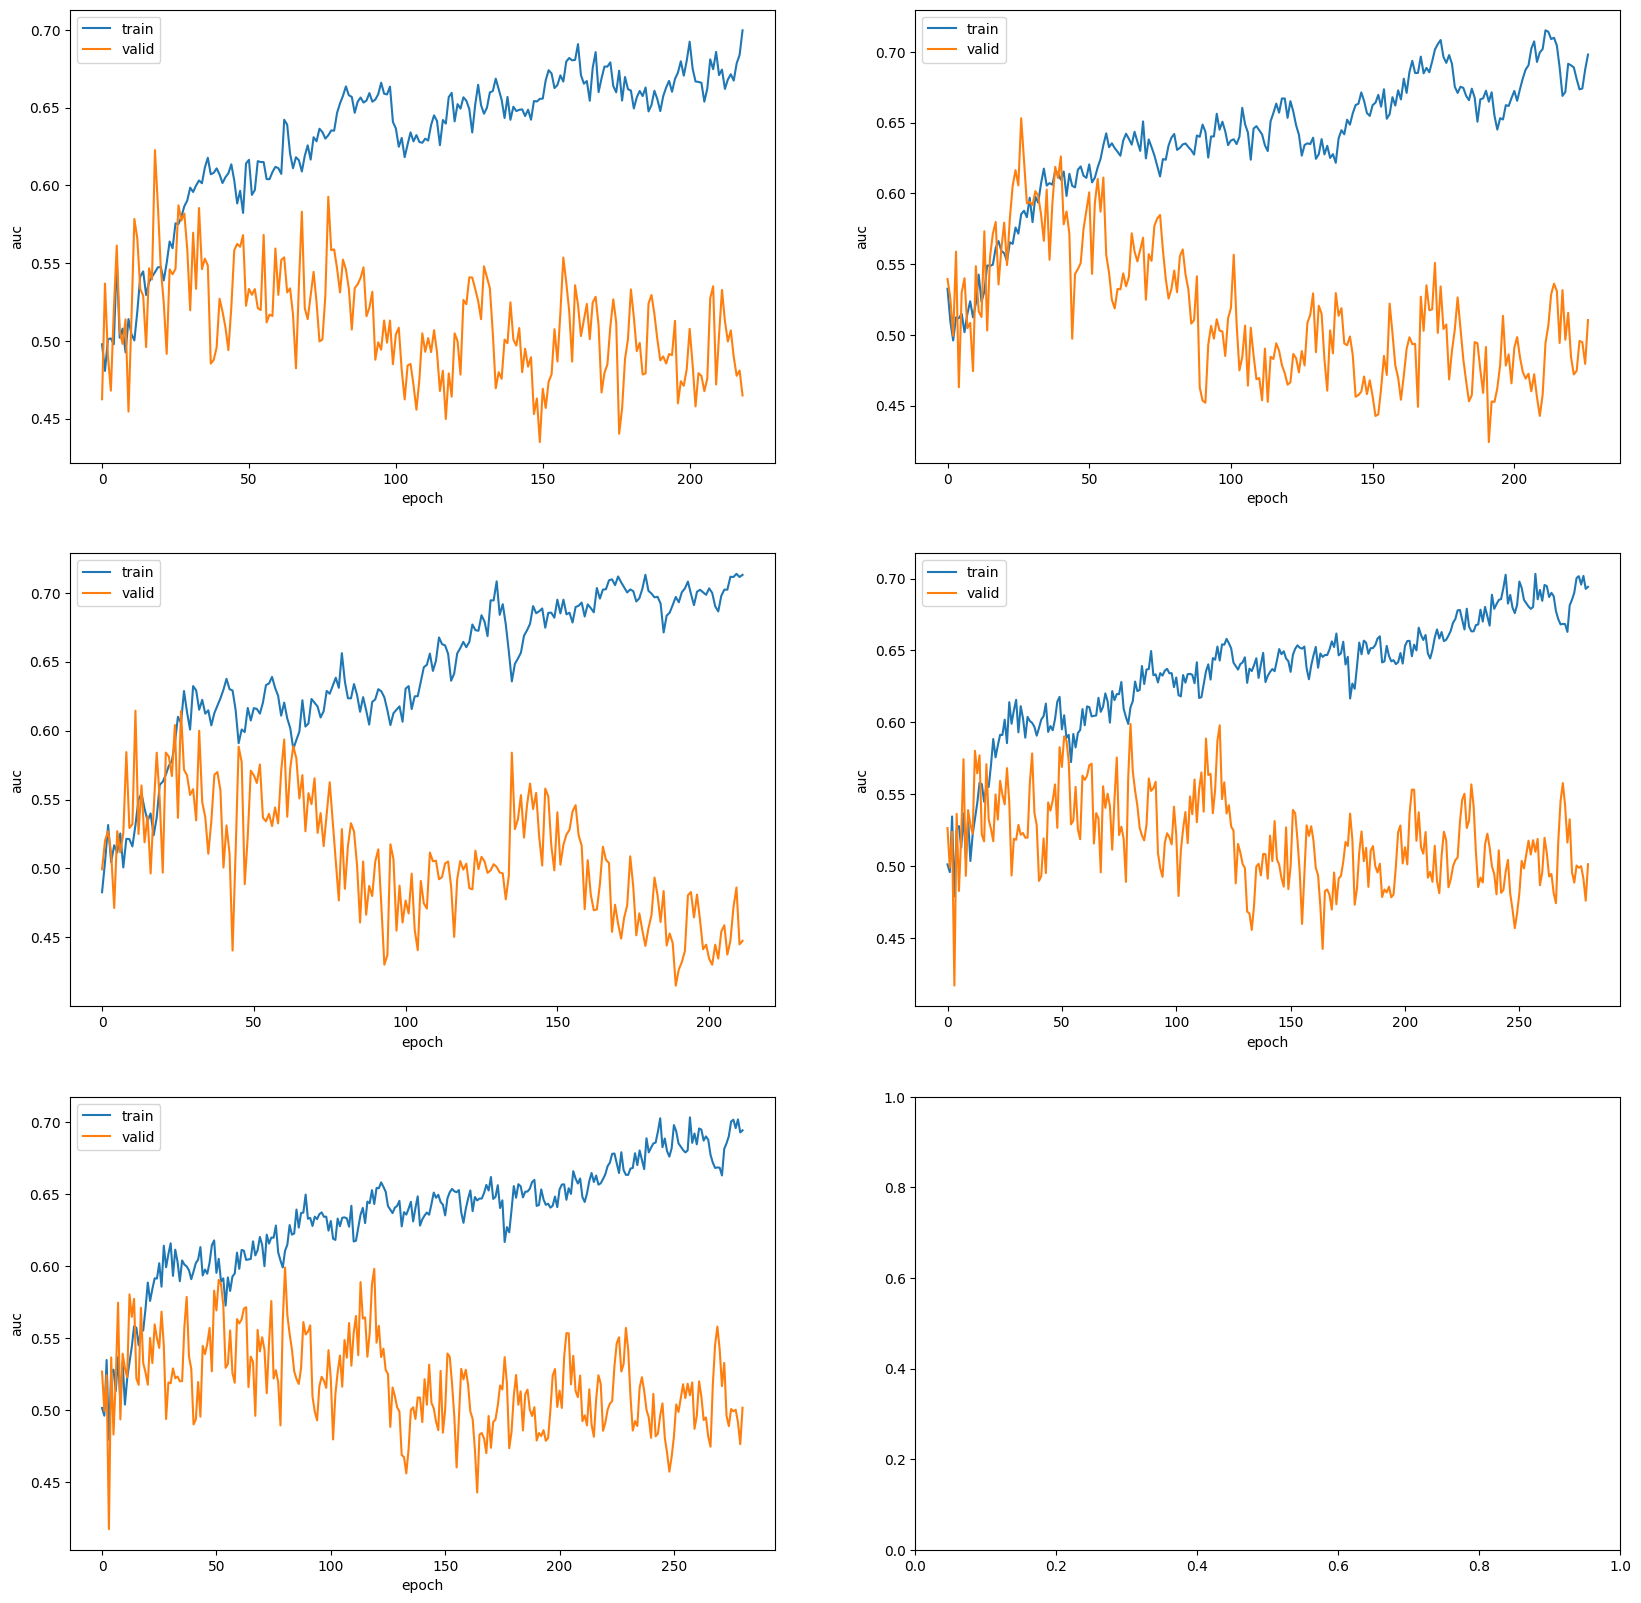

In [ ]:
a = h_ko
t = "train_auc"
v = "valid_auc"
yl = "auc"

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history[t], label="train")
ax.plot(a[0].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history[t], label="train")
ax.plot(a[1].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history[t], label="train")
ax.plot(a[2].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

plt.show()

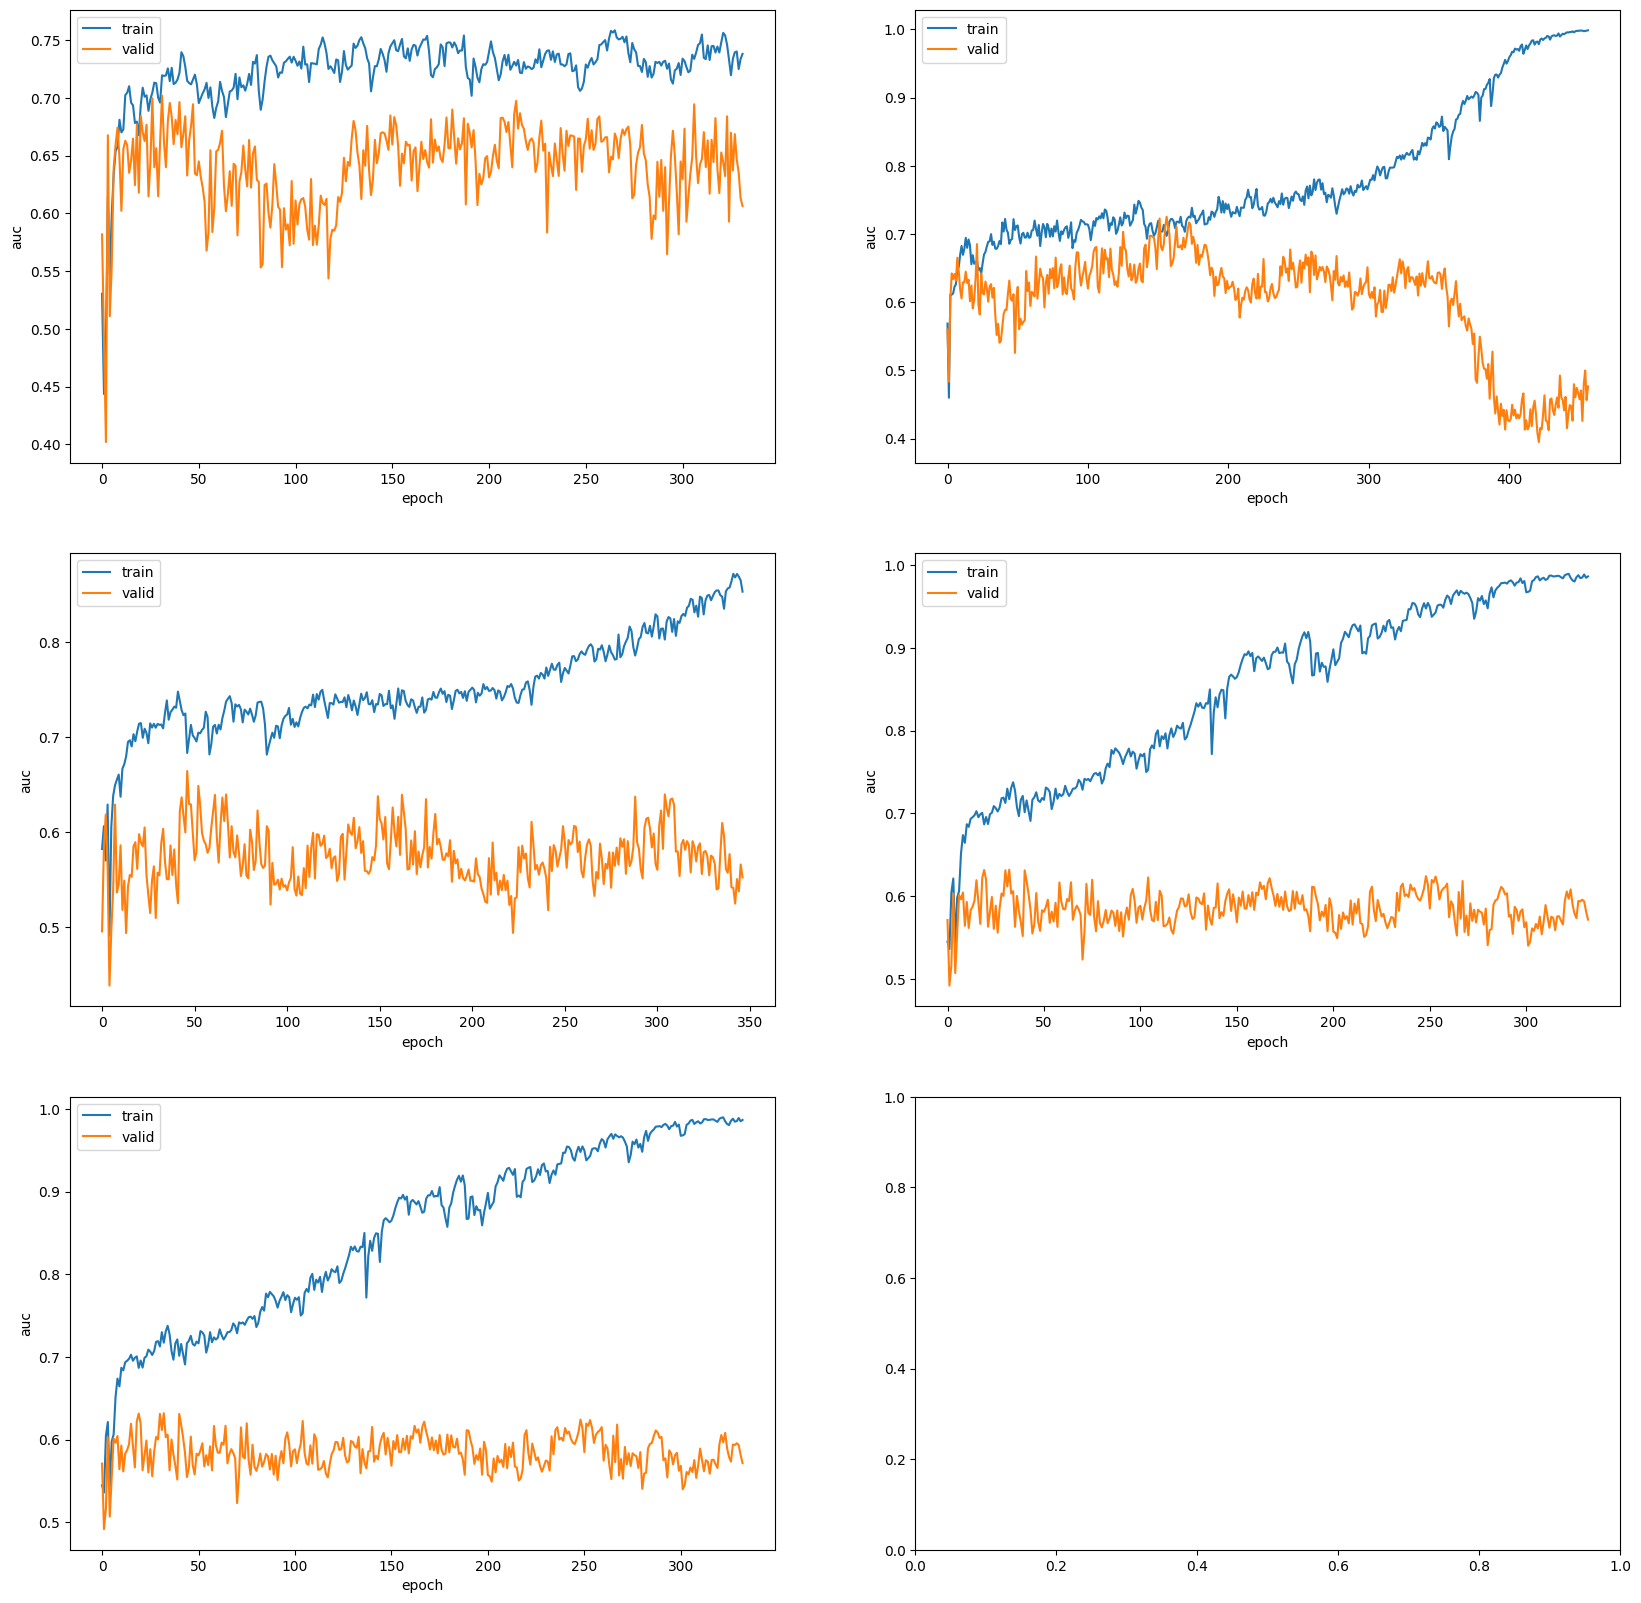

In [ ]:
a = h_uy
t = "train_auc"
v = "valid_auc"
yl = "auc"

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history[t], label="train")
ax.plot(a[0].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history[t], label="train")
ax.plot(a[1].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history[t], label="train")
ax.plot(a[2].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

plt.show()

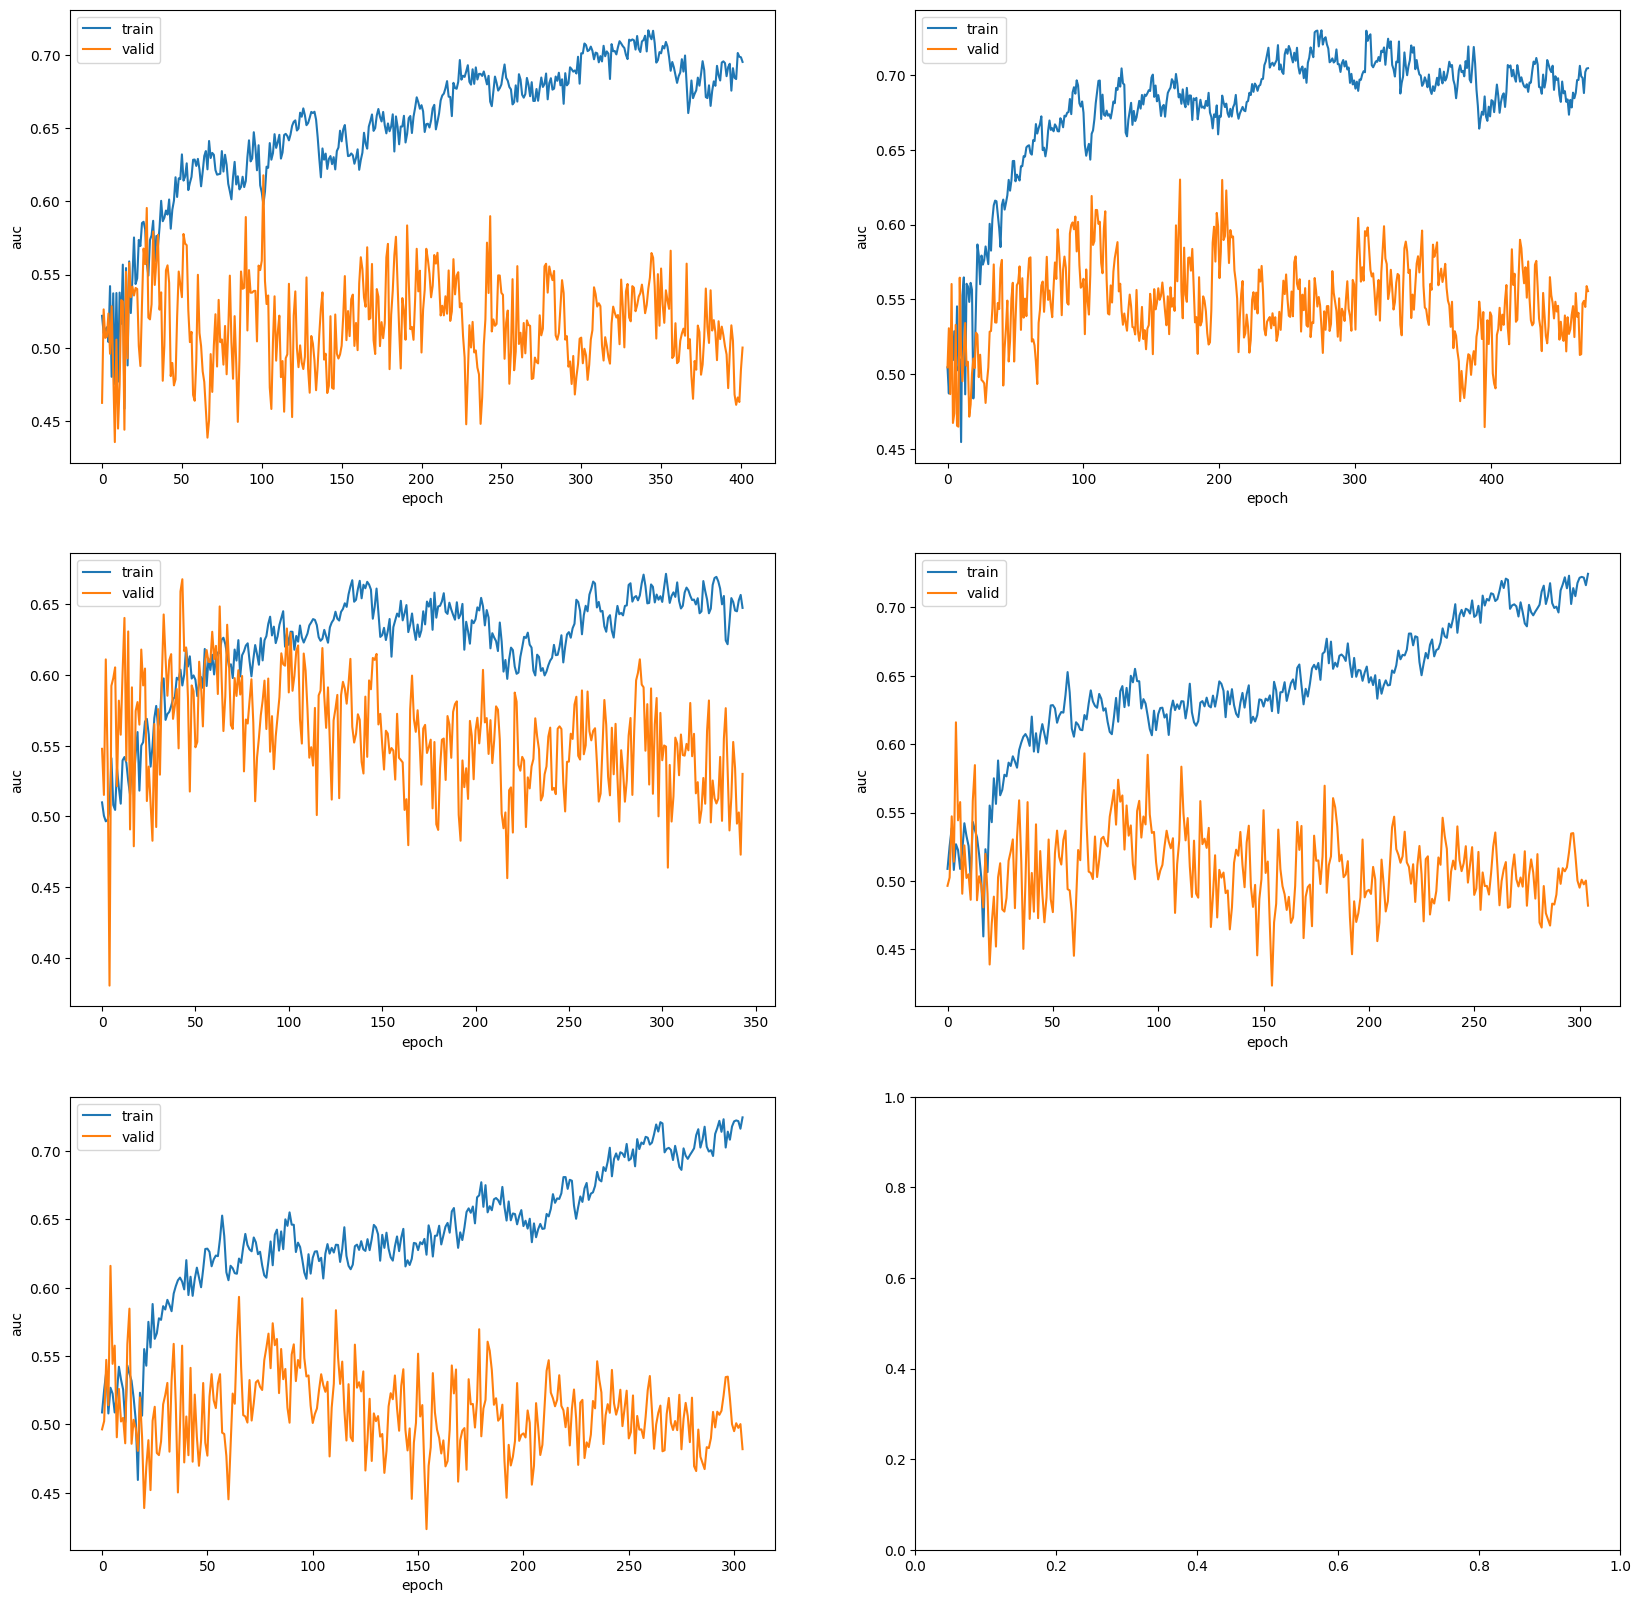

In [ ]:
a = h_uo
t = "train_auc"
v = "valid_auc"
yl = "auc"

fig, axs = plt.subplots(3, 2, figsize=(20,20))

ax = axs[0,0]
ax.plot(a[0].history[t], label="train")
ax.plot(a[0].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[0,1]
ax.plot(a[1].history[t], label="train")
ax.plot(a[1].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,0]
ax.plot(a[2].history[t], label="train")
ax.plot(a[2].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[1,1]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

ax = axs[2,0]
ax.plot(a[3].history[t], label="train")
ax.plot(a[3].history[v], label="valid")
ax.set_xlabel('epoch')
ax.set_ylabel(yl)
ax.legend()

plt.show()

### score

In [ ]:
a = pd.DataFrame(s_ky)
a.set_index([["f1", "acc", "prec", "rec"]], inplace=True)
a

0         1         2         3         4
f1    0.758700  0.721699  0.755957  0.747634  0.693765
acc   0.634146  0.584305  0.628137  0.617886  0.552846
prec  0.968747  0.969885  0.971707  0.967129  0.969032
rec   0.634146  0.584305  0.628137  0.617886  0.552846

In [ ]:
a = pd.DataFrame(s_ko)
a.set_index([["f1", "acc", "prec", "rec"]], inplace=True)
a

0         1         2         3         4
f1    0.512898  0.632131  0.653967  0.603703  0.658467
acc   0.395169  0.514976  0.534300  0.482126  0.542995
prec  0.877688  0.878398  0.886662  0.886913  0.897029
rec   0.395169  0.514976  0.534300  0.482126  0.542995

In [ ]:
a = pd.DataFrame(s_uy)
a.set_index([["f1", "acc", "prec", "rec"]], inplace=True)
a

0         1         2         3         4
f1    0.816168  0.758536  0.624565  0.749025  0.796404
acc   0.713749  0.634485  0.473704  0.617956  0.684072
prec  0.965620  0.964850  0.969104  0.971520  0.969195
rec   0.713749  0.634485  0.473704  0.617956  0.684072

In [ ]:
a = pd.DataFrame(s_uo)
a.set_index([["f1", "acc", "prec", "rec"]], inplace=True)
a

0         1         2         3         4
f1    0.582110  0.673995  0.526974  0.889884  0.670994
acc   0.462017  0.562889  0.414695  0.899128  0.565380
prec  0.887588  0.894388  0.878318  0.881869  0.895589
rec   0.462017  0.562889  0.414695  0.899128  0.565380

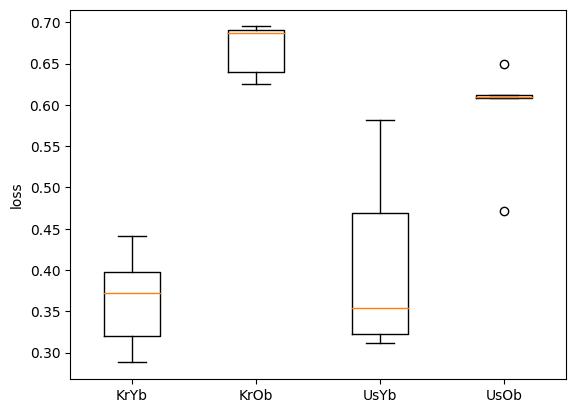

In [ ]:
idx = np.arange(1, 5)
labels = ["KrYb", "KrOb", "UsYb", "UsOb"]
data1 = [0.288, 0.372, 0.397, 0.441, 0.320]
data2 = [0.625, 0.640, 0.691, 0.687, 0.695]
data3 = [0.582, 0.354, 0.469, 0.323, 0.312]
data4 = [0.612, 0.610, 0.649, 0.608, 0.471]

plt.ylabel('loss')
plt.boxplot([data1, data2, data3, data4])
plt.xticks(idx, labels)
plt.show()

In [ ]:
import pandas as pd
scores = pd.DataFrame({"loss":[0.288, 0.372, 0.397, 0.441, 0.320,
                               0.625, 0.640, 0.691, 0.687, 0.695,
                               0.582, 0.354, 0.469, 0.323, 0.312,
                               0.612, 0.610, 0.649, 0.608, 0.471],
                       "f1":[0.759, 0.721, 0.760, 0.748, 0.694,
                             0.5113, 0.632, 0.654, 0.604, 0.658,
                             0.816, 0.759, 0.625, 0.750, 0.796,
                             0.582, 0.674, 0.527, 0.890, 0.671],
                       "AUC":[0.687, 0.688, 0.689, 0.685, 0.700,
                              0.623, 0.653, 0.614, 0.599 ,0.584,
                              0.702, 0.725, 0.664, 0.632, 0.705,
                              0.618, 0.630, 0.668, 0.616, 0.622],
                       "region":["KR","KR","KR","KR","KR",
                                 "KR","KR","KR","KR","KR",
                                 "US","US","US","US","US",
                                 "US","US","US","US","US"],
                       "age": ["<=19","<=19","<=19","<=19","<=19",
                               ">19",">19",">19",">19", ">19",
                               "<=19","<=19","<=19","<=19","<=19",
                               ">19",">19",">19",">19", ">19"]})
scores

loss      f1    AUC region   age
0   0.288  0.7590  0.687     KR  <=19
1   0.372  0.7210  0.688     KR  <=19
2   0.397  0.7600  0.689     KR  <=19
3   0.441  0.7480  0.685     KR  <=19
4   0.320  0.6940  0.700     KR  <=19
5   0.625  0.5113  0.623     KR   >19
6   0.640  0.6320  0.653     KR   >19
7   0.691  0.6540  0.614     KR   >19
8   0.687  0.6040  0.599     KR   >19
9   0.695  0.6580  0.584     KR   >19
10  0.582  0.8160  0.702     US  <=19
11  0.354  0.7590  0.725     US  <=19
12  0.469  0.6250  0.664     US  <=19
13  0.323  0.7500  0.632     US  <=19
14  0.312  0.7960  0.705     US  <=19
15  0.612  0.5820  0.618     US   >19
16  0.610  0.6740  0.630     US   >19
17  0.649  0.5270  0.668     US   >19
18  0.608  0.8900  0.616     US   >19
19  0.471  0.6710  0.622     US   >19

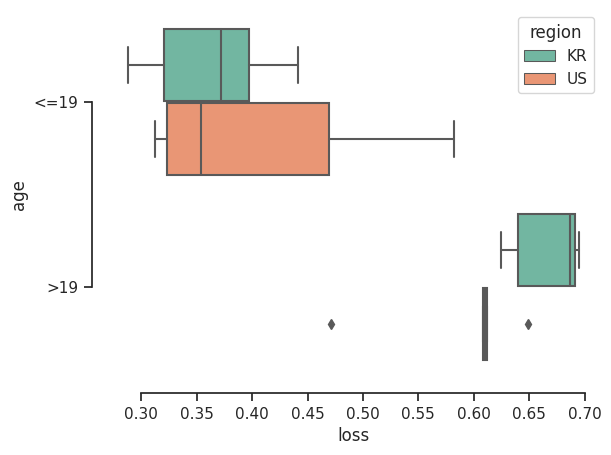

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="Set2")

sns.boxplot(x="loss", y="age",
            hue="region",
            orient="h",
            data=scores)
sns.despine(offset=10, trim=True)

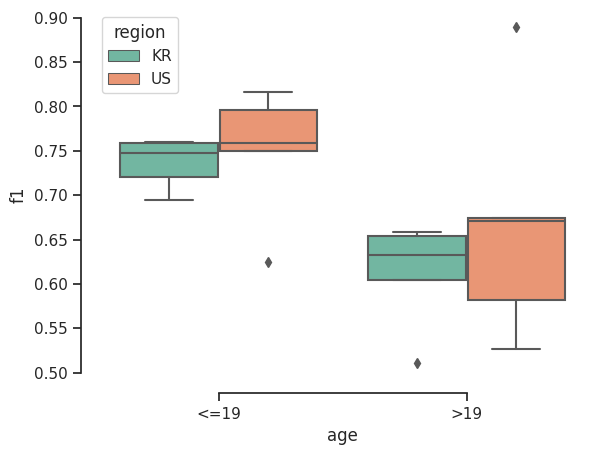

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="Set2")

sns.boxplot(x="f1", y="age",
            hue="region",
            data=scores)
sns.despine(offset=10, trim=True)

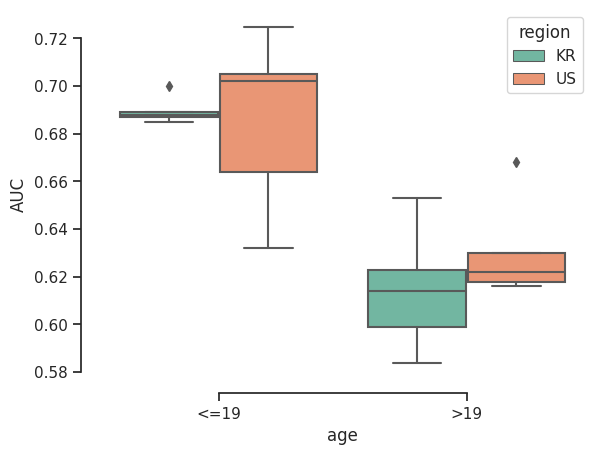

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="Set2")

sns.boxplot(x="age", y="AUC",
            hue="region",
            data=scores)
sns.despine(offset=10, trim=True)